In [1]:
# plotting modules
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import hvplot.xarray # noqa
#import panel as pn
from rasterio.plot import show

# general modules
import rasterio
import xarray as xr
from shapely import Point
import numpy as np
from datetime import date
import os
from netCDF4 import Dataset
import pandas as pd

# spafhy tool modules
from iotools import read_AsciiGrid, write_AsciiGrid, read_results
from raster_utils import read_pkrasteri_for_extent
from metrics import R2_metrics, MBE_metrics, MAE_metrics, histogram_match, calc_kge


os.chdir(r'C:\SpaFHy_v1_Pallas_2D\figures')
plt.rcParams['axes.grid'] = True
degree_sign = u'\N{DEGREE SIGN}'

#%%

## reading simulation results
# reading the 1D results
#outputfile_1d = r'F:\SpaFHy_2D_2021\res_1d_9.nc'
outputfile_1d = r'F:\SpaFHy_2D_2021\res_1d_24c.nc'
#outputfile_1d_ave = r'F:\SpaFHy_2D_2021\res_1d_ave_9.nc'
outputfile_1d_ave = r'F:\SpaFHy_2D_2021\res_1d_ave_24c.nc'

res_1d = xr.open_dataset(outputfile_1d)
res_1d_ave = xr.open_dataset(outputfile_1d_ave)
#res_1d_ndr = xr.open_dataset(outputfile_1d_ndr)
#res_1d_sc2 = xr.open_dataset(outputfile_1d_sc2)

# reading the 2D results
#outputfile_2d = r'F:/SpaFHy_2D_2021/res_2d_new_por.nc'
outputfile_2d = r'F:/SpaFHy_2D_2021/res_2d_24c.nc'

outputfile_2d_ave = r'F:\SpaFHy_2D_2021\res_2d_ave_9.nc'
#outputfile_2d_ndr = r'F:\SpaFHy_2D_2021\res_2d_ndr_newnew_23.nc'
res_2d = xr.open_dataset(outputfile_2d)
res_2d_ave = xr.open_dataset(outputfile_2d_ave)
#res_2d_ndr = xr.open_dataset(outputfile_2d_ndr)

# reading the top results
#outputfile_top = r'F:\SpaFHy_2D_2021\res_top_12.nc'
outputfile_top = r'F:\SpaFHy_2D_2021\res_top_24c.nc'

res_top = xr.open_dataset(outputfile_top)
res_top['total_evapotranspiration'] = res_top['bucket_evaporation'] + res_top['canopy_transpiration'] + res_top['canopy_evaporation']
res_2d['total_evapotranspiration'] = res_2d['bucket_evaporation'] + res_2d['canopy_transpiration'] + res_2d['canopy_evaporation']
res_1d['total_evapotranspiration'] = res_1d['bucket_evaporation'] + res_1d['canopy_transpiration'] + res_1d['canopy_evaporation']
res_1d_ave['total_evapotranspiration'] = res_1d_ave['bucket_evaporation'] + res_1d_ave['canopy_transpiration'] + res_1d_ave['canopy_evaporation']

# raster parameters
soilclass = np.array(res_2d['parameters_soilclass'])
cmask = np.array(res_2d['parameters_cmask'])
dmask = np.array(res_2d['parameters_ditches'])
dmask = np.where(dmask < 0, np.nan, 1)
#dmask[np.where(dmask == 0)] = 1
#dmask[np.where(dmask < 0)] = np.nan

peat_id = np.where(np.ravel(soilclass == 4))[0]
peat_2d = np.where(soilclass == 4)
mineral_id = np.where(np.ravel(soilclass == 2))[0]
mineral_2d = np.where(soilclass == 2)

dates_spa = []
for d in range(len(res_1d['time'])):
    dates_spa.append(pd.to_datetime(str(res_1d['time'][d])[36:46]))
dates_spa = pd.to_datetime(dates_spa)

# reading basic map
pkfp = 'C:\SpaFHy_v1_Pallas_2D/testcase_input/parameters/pkmosaic_clipped.tif'
bbox = [res_1d['lon'].min(), res_1d['lon'].max(), res_1d['lat'].min(), res_1d['lat'].max()]
pk, meta = read_pkrasteri_for_extent(pkfp, bbox, showfig=False)

# reading SAR files
sar_mfile = r'F:\SpaFHy_2D_2021\PALLAS_RAW_DATA\SAR_maankosteus\processed\m16_nc_spafhy_pallas\original\SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_morning.nc'
sar_m = xr.open_dataset(sar_mfile) * cmask

sar_efile = r'F:\SpaFHy_2D_2021\PALLAS_RAW_DATA\SAR_maankosteus\processed\m16_nc_spafhy_pallas\original\SAR_SM_PALLAS_2019_16M_TM35_CATCHMENT_evening.nc'
sar_e = xr.open_dataset(sar_efile) * cmask

dates_sar_m = []
dates_sar_e = []

for d in range(len(sar_m['time'])):
    dates_sar_m.append(pd.to_datetime(str(sar_m['time'][d])[36:46]))
    dates_sar_e.append(pd.to_datetime(str(sar_e['time'][d])[36:46]))

dates_sar_m = pd.to_datetime(dates_sar_m).sort_values()
dates_sar_e = pd.to_datetime(dates_sar_e).sort_values()

sar_mask = np.array(sar_m['theta'][0].copy())
sar_mask[sar_mask >= 0] = 1
sar_mask = sar_mask.reshape(sar_m['theta'][0].shape) * cmask

# parameters
today = date.today()
saveplots = True

# distributed radiation
distradfile = r'C:\SpaFHy_v1_Pallas_2D/obs/rad_ds.nc'
distrad = xr.open_dataset(distradfile)

res_2d['parameters_lai_tot'] = res_2d['parameters_lai_conif'] + res_2d['parameters_lai_decid_max'] + res_2d['parameters_lai_grass'] + res_2d['parameters_lai_shrub']
res_2d_ave['parameters_lai_tot'] = res_2d_ave['parameters_lai_conif'] + res_2d_ave['parameters_lai_decid_max'] + res_2d_ave['parameters_lai_grass'] + res_2d_ave['parameters_lai_shrub']

res_1d['parameters_lai_tot'] = res_1d['parameters_lai_conif'] + res_1d['parameters_lai_decid_max'] + res_1d['parameters_lai_grass'] + res_1d['parameters_lai_shrub']
res_1d_ave['parameters_lai_tot'] = res_1d_ave['parameters_lai_conif'] + res_1d_ave['parameters_lai_decid_max'] + res_1d_ave['parameters_lai_grass'] + res_1d_ave['parameters_lai_shrub']

# indexes for tighet plots
zx = np.arange(20, 171, 1)
zy = np.arange(20, 246, 1)

# defining important raster locations
ht = [118,136] # hilltop
om = [46, 54]   # open mire

ffile = r'C:\SpaFHy_v1_Pallas_2D/testcase_input/forcing/Kenttarova_forcing_era5.csv'
forc = pd.read_csv(ffile, sep=';', index_col=0, parse_dates=True)

#%%

# simple tests for simulation files
try:
    res_1d['time'] in res_2d['time'] in res_top['time']
    print('Simulation times are a MATCH!')
except ValueError:
    print('Simulation times DO NOT match!')
try:
    res_1d['lat'] in res_2d['lat'] in res_top['lat'] and res_1d['lon'] in res_2d['lon'] in res_top['lon']
    print('Simulation extents are a MATCH!')
except ValueError:
    print('Simulation extents DO NOT match!')

# simple tests for SAR files # !!! if false does not print DO NOT
try:
    sar_m['time'] in sar_e['time']
    print('SAR dates are a MATCH!')
except ValueError:
    print('SAR dates DO NOT match!')
try:
    sar_m['lat'] in sar_e['lat'] and sar_m['lon'] in sar_e['lon']
    print('SAR extents are a MATCH!')
except ValueError:
    print('SAR extents DO NOT match!')

# simple tests for SAR + SpaFHy files
try:
    sar_m['lat'] in sar_e['lat'] in res_1d['lat'] and sar_m['lon'] in sar_e['lon'] in res_1d['lon']
    print('SAR and SpaFHy extents are a MATCH!')
except ValueError:
    print('SAR and SpaFHy extents DO NOT match!')
try:
    sar_m['time'] in sar_e['time'] in res_1d['time']
    print('SAR and SpaFHy times are a MATCH!')
except ValueError:
    print('SAR and SpaFHy times DO NOT match!')

Simulation times are a MATCH!
Simulation extents are a MATCH!
SAR dates are a MATCH!
SAR extents are a MATCH!
SAR and SpaFHy extents are a MATCH!
SAR and SpaFHy times are a MATCH!


In [2]:
import geopandas as gpd
# READING POINT OBSERVATIONS

# 1 discharge
fn1 = r'C:\SpaFHy_v1_Pallas_2D\obs\Runoffs1d_SVEcatchments_mmd_new.csv'
q = pd.read_csv(fn1, sep=';', index_col=0, parse_dates=True)
q = q.loc[q.index.isin(dates_spa)]
q['2D'] = (res_2d['bucket_surface_runoff'].mean(dim=['lat', 'lon']) + res_2d['soil_netflow_to_ditch'].mean(dim=['lat', 'lon']))
q['TOP'] = (res_top['bucket_surface_runoff'].mean(dim=['lat', 'lon']) + res_top['top_baseflow'])

# 2 swe
fn2 = r'C:\SpaFHy_v1_Pallas_2D\obs\swe_sites.csv'
swe = pd.read_csv(fn2, sep=';', index_col=0, parse_dates=True)

# 3 kenttärova soil moisture
fn3 = r'C:\SpaFHy_v1_Pallas_2D\obs\theta_kenttarova.csv'
theta = pd.read_csv(fn3, sep=';', index_col=0, parse_dates=True)

# 4 groundwater levels
fn4 = r'C:\SpaFHy_v1_Pallas_2D\obs\gw_levels.csv'
fn4b = r'C:\Users\janousu\OneDrive - Oulun yliopisto\Pallas data\DATABASE\GROUNDWATER LEVELS\LEVELOGGERS\pipe_coordinates.csv'
gw = pd.read_csv(fn4, sep=';', index_col=0, parse_dates=True)
gw = gw.rename(columns={'pvp01': 'PVP1', 'pvp02': 'PVP2', 'pvp03': 'PVP3', 'pvp04': 'PVP4', 'pvp05': 'PVP5', 'pvp06': 'PVP6',
                       'pvp07': 'PVP7', 'pvp08': 'PVP8', 'pvp09': 'PVP9', 'pvp11': 'PVP11', 'pzp01': 'PZ1', 'pzp02': 'PZ2', 'pzp03':'PZ3'})
gwc = pd.read_csv(fn4b, sep=';')
gwc['geometry'] = np.nan
for i in range(len(gwc)):
    gwc.loc[i, 'geometry'] = Point(gwc.loc[i, 'Longitude'], gwc.loc[i, 'Latitude'])
gwc = gpd.GeoDataFrame(gwc[['Pipe', 'geometry']])

# 5 evapotranspiration
fn5 = r'C:\SpaFHy_v1_Pallas_2D\obs\ec_et_new.csv'
et = pd.read_csv(fn5, sep=';', index_col=0, parse_dates=True)

# 6 spatial soil moisture
fn6 = r'C:\SpaFHy_v1_Pallas_2D\obs\theta_spatial.nc'
theta_spat = xr.open_dataset(fn6)

# 7 spatial soil moisture geopandas
fn7 = r'C:\Users\janousu\OneDrive - Oulun yliopisto\Pallas data\DATABASE\SOIL MOISTURE AND TEMPERATURE\PROCESSING\Spatial\final_catchment_SM_mean_gpd_JP.csv'
theta_spat_gpd = pd.read_csv(fn7, sep=';', index_col=0, parse_dates=True)
theta_spat_gpd = gpd.GeoDataFrame(theta_spat_gpd)
theta_spat_gpd['geometry'] = gpd.GeoSeries.from_wkt(theta_spat_gpd['geometry'])
theta_spat_gpd = theta_spat_gpd.loc[~((theta_spat_gpd['ID_i'] == 'i2') | (theta_spat_gpd['ID_i'] == 'i3') | (theta_spat_gpd['ID_i'] == 'i4') | (theta_spat_gpd['ID_i'] == 'i5') | (theta_spat_gpd['ID_i'] == 'i1'))]

In [3]:
# creating pd dataframes for those sim vs. obs we want scatterplots of
# spatial manual measurements and closest grid-cell
spat_theta_pair = pd.DataFrame()
obs_list = []
mod_list_1d = []
mod_list_2d = []
mod_list_top = []
sar_e_list = []
sar_m_list = []
mod_list_1d_peat = []
mod_list_2d_peat = []
mod_list_top_peat = []
sar_e_list_peat = []
sar_m_list_peat = []
mod_list_1d_mineral = []
mod_list_2d_mineral = []
mod_list_top_mineral = []
sar_e_list_mineral = []
sar_m_list_mineral = []

soiltype = []
sitetype = []
canopy_fraction = []
twi = []

for i in theta_spat_gpd.index.unique():
    data = theta_spat_gpd.loc[i]
    #data = data.loc[data['z'] != 0]
    for j in data['ID_i'].unique():
        point = data.loc[data['ID_i'] == j]
        coords = point['geometry'][0]
        time = point.index[0]
        if len(point) > 1:
            theta_obs = float(point['theta'].mean())
        else:
            theta_obs = float(point['theta'])
        soiltype.append(float(res_2d['parameters_soilclass'].sel(lat=coords.y, lon=coords.x, method='nearest')))
        sitetype.append(float(res_2d['parameters_sitetype'].sel(lat=coords.y, lon=coords.x, method='nearest')))
        canopy_fraction.append(float(res_2d['parameters_cf'].sel(lat=coords.y, lon=coords.x, method='nearest')))
        twi.append(float(res_top['parameters_twi'].sel(lat=coords.y, lon=coords.x, method='nearest')))
        obs_list.append(theta_obs)
        mod_list_top.append(float(res_top['bucket_moisture_root'].sel(time=time,
                                                           lat=coords.y, lon=coords.x,
                                                           method='nearest')))
        mod_list_1d.append(float(res_1d['bucket_moisture_root'].sel(time=time,
                                                           lat=coords.y, lon=coords.x,
                                                           method='nearest')))
        mod_list_2d.append(float(res_2d['bucket_moisture_root'].sel(time=time,
                                                           lat=coords.y, lon=coords.x,
                                                           method='nearest')))
        if time in sar_m['time']:
            sar_m_list.append(float(sar_m['theta'].sel(time=time).sel(lat=coords.y, lon=coords.x, method='nearest')))
        else:
            sar_m_list.append(np.nan)
        if time in sar_e['time']:
            sar_e_list.append(float(sar_e['theta'].sel(time=time).sel(lat=coords.y, lon=coords.x,method='nearest')))
        else:
            sar_e_list.append(np.nan)            
spat_theta_pair['obs'] = obs_list
spat_theta_pair['mod_1d'] = mod_list_1d
spat_theta_pair['mod_2d'] = mod_list_2d
spat_theta_pair['mod_top'] = mod_list_top
spat_theta_pair['soiltype'] = soiltype
spat_theta_pair['sitetype'] = sitetype
spat_theta_pair['canopy_fraction'] = canopy_fraction
spat_theta_pair['twi'] = twi
spat_theta_pair['sar_e'] = sar_e_list
spat_theta_pair['sar_m'] = sar_m_list
spat_theta_pair['sar'] = np.nan
spat_theta_pair['sar'] = spat_theta_pair['sar'].fillna(spat_theta_pair['sar_e'])
spat_theta_pair['sar'] = spat_theta_pair['sar'].fillna(spat_theta_pair['sar_m'])

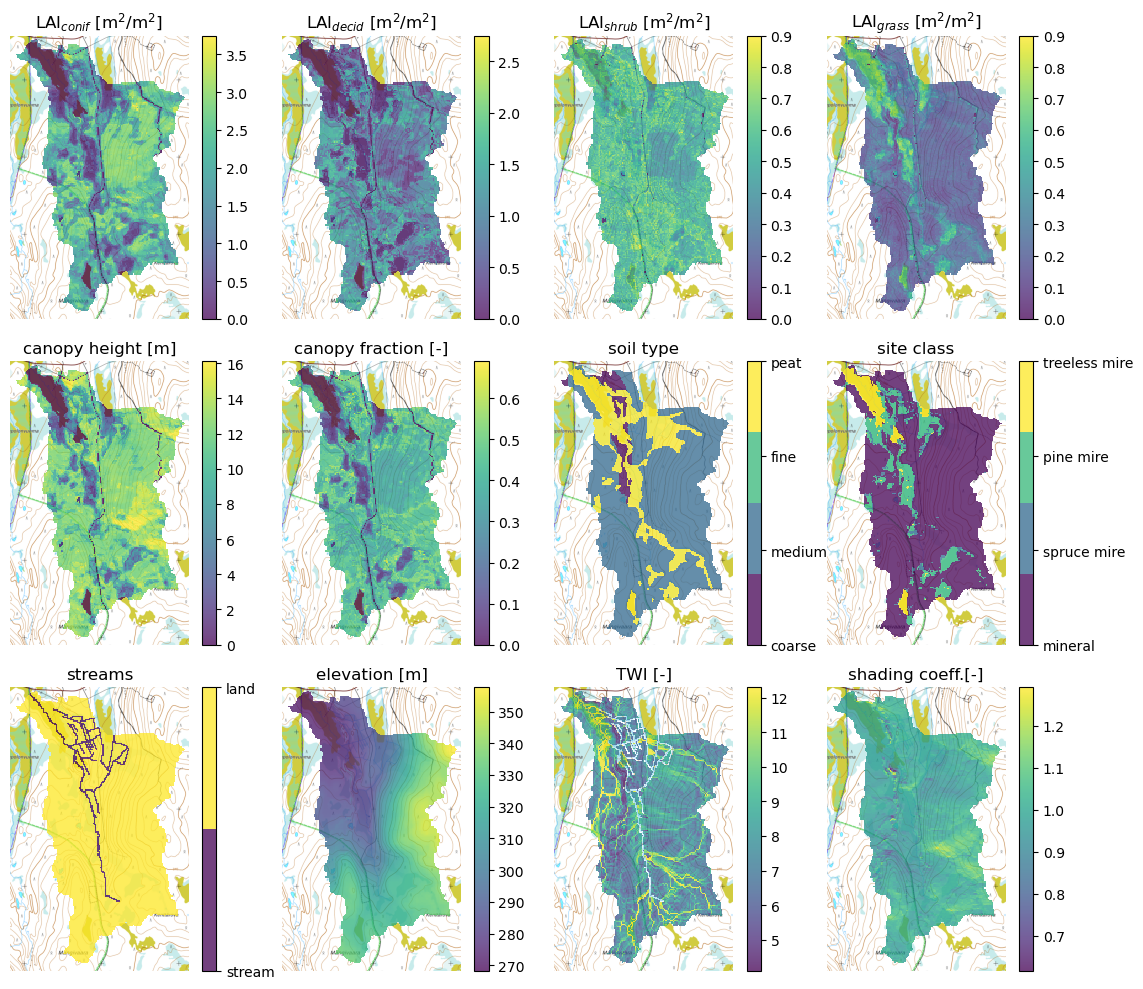

In [44]:
import matplotlib.ticker as mticker

os.chdir(r'C:\SpaFHy_v1_Pallas_2D\figures')

alp=0.75

# GIS PLOT

# Plotting
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12,10));
ax1 = axs[0][0]
ax2 = axs[0][1]
ax3 = axs[0][2]
ax4 = axs[0][3]

ax5 = axs[1][0]
ax6 = axs[1][1]
ax7 = axs[1][2]
ax8 = axs[1][3]

ax9 = axs[2][0]
ax10 = axs[2][1]
ax11 = axs[2][2]
ax12 = axs[2][3]


#im1 = ax1.imshow(res_2d['parameters_lai_conif'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax1);
im1 = res_2d['parameters_lai_conif'][20:250,20:165].plot(ax=ax1, alpha=alp, add_colorbar=False, vmin=0, vmax=3.75)
ax1.set_title(r'LAI$_{conif}$ [m$^2$/m$^2$]', y=1)
fig.colorbar(im1, ax=ax1)

#im2 = ax2.imshow(res_2d['parameters_lai_decid_max'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
im2 = res_2d['parameters_lai_decid_max'][20:250,20:165].plot(ax=ax2, alpha=alp, add_colorbar=False, vmin=0, vmax=2.75)
ax2.set_title(r'LAI$_{decid}$ [m$^2$/m$^2$]', y=1)
fig.colorbar(im2, ax=ax2)

#im3 = ax3.imshow(res_2d['parameters_lai_shrub'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax3);
im3 = res_2d['parameters_lai_shrub'][20:250,20:165].plot(ax=ax3, alpha=alp, add_colorbar=False, vmin=0, vmax=0.9)
ax3.set_title(r'LAI$_{shrub}$ [m$^2$/m$^2$]', y=1)
fig.colorbar(im3, ax=ax3)

#im4 = ax4.imshow(res_2d['parameters_lai_grass'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax4);
im4 = res_2d['parameters_lai_grass'][20:250,20:165].plot(ax=ax4, alpha=alp, add_colorbar=False, vmin=0, vmax=0.9)
ax4.set_title(r'LAI$_{grass}$ [m$^2$/m$^2$]', y=1)
fig.colorbar(im4, ax=ax4)

#im5 = ax5.imshow(res_2d['parameters_hc'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax5);
im5 = res_2d['parameters_hc'][20:250,20:165].plot(ax=ax5, alpha=alp, add_colorbar=False)
ax5.set_title('canopy height [m]', y=1)
fig.colorbar(im5, ax=ax5)

#im6 = ax6.imshow(res_2d['parameters_cf'][20:250,20:165], label='canopy fraction')
rasterio.plot.show(pk, transform=meta['transform'], ax=ax6);
im6 = res_2d['parameters_cf'][20:250,20:165].plot(ax=ax6, alpha=alp, add_colorbar=False)
ax6.set_title('canopy fraction [-]', y=1)
fig.colorbar(im6, ax=ax6)

cmapsoil = plt.get_cmap('viridis', 4)
#im7 = ax7.imshow(res_2d['parameters_soilclass'][20:250,20:165], cmap=cmapsoil)
rasterio.plot.show(pk, transform=meta['transform'], ax=ax7);
im7 = res_2d['parameters_soilclass'][20:250,20:165].plot(ax=ax7, alpha=alp, cmap=cmapsoil, add_colorbar=False)
ax7.set_title('soil type', y=1)
cbar = fig.colorbar(im7, ax=ax7)
#cbar.ax.locator_params(nbins=4)
#cbar.ax.set_yticklabels(['coarse', 'medium', 'fine', 'peat'])
tick_locs   = [1, 2, 3, 4]
tick_labels = ['coarse', 'medium', 'fine', 'peat']
cbar.locator     = mticker.FixedLocator(tick_locs)
cbar.formatter   = mticker.FixedFormatter(tick_labels)
cbar.update_ticks()

cmapsite = plt.get_cmap('viridis', 4)
#im8 = ax8.imshow(res_2d['parameters_sitetype'][20:250,20:165], cmap=cmapsite)
rasterio.plot.show(pk, transform=meta['transform'], ax=ax8);
im8 = res_2d['parameters_sitetype'][20:250,20:165].plot(ax=ax8, alpha=alp, cmap=cmapsite, add_colorbar=False)
ax8.set_title('site class', y=1)
cbar = fig.colorbar(im8, ax=ax8)
#cbar.ax.locator_params(nbins=4)
#cbar.ax.set_yticklabels(['forest', 'spruce mire', 'pine mire', 'open mire'])
tick_locs   = [1, 2, 3, 4]
tick_labels = ['mineral', 'spruce mire', 'pine mire', 'treeless mire']
cbar.locator     = mticker.FixedLocator(tick_locs)
cbar.formatter   = mticker.FixedFormatter(tick_labels)
cbar.update_ticks()

cmapditch = plt.get_cmap('viridis', 2)
#im9 = ax9.imshow(res_2d['parameters_ditches'][20:250,20:165], cmap=cmapditch)
rasterio.plot.show(pk, transform=meta['transform'], ax=ax9);
im9 = res_2d['parameters_ditches'][20:250,20:165].plot(ax=ax9, alpha=alp, cmap=cmapditch, add_colorbar=False)
ax9.set_title('streams', y=1)
cbar = fig.colorbar(im9, ax=ax9)
#cbar.ax.locator_params(nbins=1)
tick_locs   = [-0.2, 0]
tick_labels = ['stream', 'land']
cbar.locator     = mticker.FixedLocator(tick_locs)
cbar.formatter   = mticker.FixedFormatter(tick_labels)
cbar.update_ticks()

#cbar.ax.set_yticklabels(tick_labels)
# = ax10.imshow(res_2d['parameters_elevation'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax10);
im10 = res_2d['parameters_elevation'][20:250,20:165].plot(ax=ax10, alpha=alp, add_colorbar=False)
ax10.set_title('elevation [m]', y=1)
fig.colorbar(im10, ax=ax10)

#im11 = ax11.imshow(res_top['parameters_twi'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax11);
im11 = res_top['parameters_twi'][20:250,20:165].plot(ax=ax11, alpha=alp, add_colorbar=False)
ax11.set_title('TWI [-]')
fig.colorbar(im11, ax=ax11)

#im12 = ax12.imshow(results_catch['parameters_twi'][20:250,20:165])
rasterio.plot.show(pk, transform=meta['transform'], ax=ax12);
im12 = (distrad['c_rad'].mean(dim='time')*cmask)[20:250,20:165].plot(ax=ax12, alpha=alp, add_colorbar=False)
ax12.set_title('shading coeff.[-]', y=1)
fig.colorbar(im12, ax=ax12)

ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax5.axis('off'); ax6.axis('off'); ax7.axis('off'); ax8.axis('off')
ax9.axis('off'); ax10.axis('off'); ax11.axis('off'); ax12.axis('off')

#plt.tight_layout()
#ax10.imshow(results_2d['parameters_twi'][20:250,20:165])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.15)

if saveplots == True:
        #plt.savefig(f'GIS_rasters_{today}.pdf',bbox_inches='tight', dpi=300)
        plt.savefig(f'GIS_rasters_{today}.png',bbox_inches='tight', dpi=300)

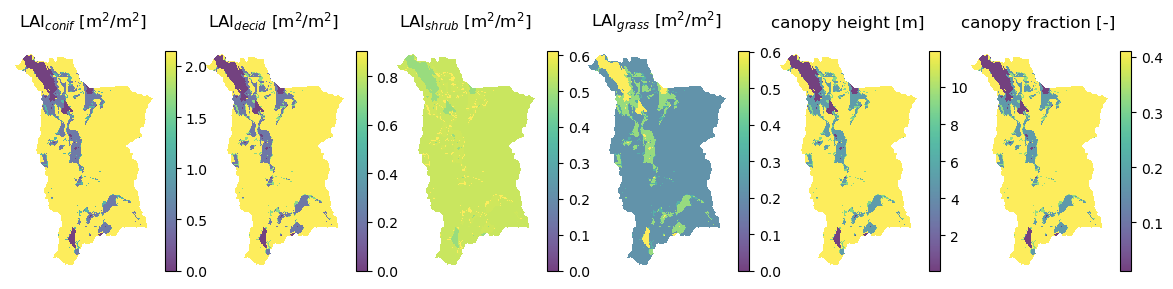

In [7]:
import matplotlib.ticker as mticker

os.chdir(r'C:\SpaFHy_v1_Pallas_2D\figures')

alp=0.75

# GIS PLOT

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12,3));
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]
ax5 = axs[4]
ax6 = axs[5]


#im1 = ax1.imshow(res_2d['parameters_lai_conif'][20:250,20:165])
im1 = res_2d_ave['parameters_lai_conif'][20:250,20:165].plot(ax=ax1, alpha=alp, add_colorbar=False, vmin=0)
ax1.set_title(r'LAI$_{conif}$ [m$^2$/m$^2$]')
fig.colorbar(im1, ax=ax1)

#im2 = ax2.imshow(res_2d['parameters_lai_decid_max'][20:250,20:165])
im2 = res_2d_ave['parameters_lai_decid_max'][20:250,20:165].plot(ax=ax2, alpha=alp, add_colorbar=False, vmin=0)
ax2.set_title(r'LAI$_{decid}$ [m$^2$/m$^2$]')
fig.colorbar(im2, ax=ax2)

#im3 = ax3.imshow(res_2d['parameters_lai_shrub'][20:250,20:165])
im3 = res_2d_ave['parameters_lai_shrub'][20:250,20:165].plot(ax=ax3, alpha=alp, add_colorbar=False, vmin=0)
ax3.set_title(r'LAI$_{shrub}$ [m$^2$/m$^2$]')
fig.colorbar(im3, ax=ax3)

#im4 = ax4.imshow(res_2d['parameters_lai_grass'][20:250,20:165])
im4 = res_2d_ave['parameters_lai_grass'][20:250,20:165].plot(ax=ax4, alpha=alp, add_colorbar=False, vmin=0)
ax4.set_title(r'LAI$_{grass}$ [m$^2$/m$^2$]')
fig.colorbar(im4, ax=ax4)

#im5 = ax5.imshow(res_2d['parameters_hc'][20:250,20:165])
im5 = res_2d_ave['parameters_hc'][20:250,20:165].plot(ax=ax5, alpha=alp, add_colorbar=False)
ax5.set_title('canopy height [m]')
fig.colorbar(im5, ax=ax5)

#im6 = ax6.imshow(res_2d['parameters_cf'][20:250,20:165], label='canopy fraction')
im6 = res_2d_ave['parameters_cf'][20:250,20:165].plot(ax=ax6, alpha=alp, add_colorbar=False)
ax6.set_title('canopy fraction [-]')
fig.colorbar(im6, ax=ax6)

ax1.axis('off'); ax2.axis('off'); ax3.axis('off'); ax4.axis('off')
ax5.axis('off'); ax6.axis('off');

#plt.tight_layout()
#ax10.imshow(results_2d['parameters_twi'][20:250,20:165])
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.15)

if saveplots == True:
        plt.savefig(f'GIS_rasters_ave_{today}.pdf',bbox_inches='tight', dpi=300)
        plt.savefig(f'GIS_rasters_ave_{today}.png',bbox_inches='tight', dpi=300)

In [4]:
####################################################
# WATER BALANCE ANNUAL PLOT
####################################################

# yearly water balance in meters for whole area
wbdf = pd.DataFrame()
wbdf['P'] = res_2d['forcing_precipitation']
wbdf['SWE'] = np.nanmean(res_1d['canopy_snowfall'], axis=(1,2))
wbdf.index = dates_spa
wbdf['Qmod'] = res_top['top_baseflow'] + np.nanmean(res_top['bucket_surface_runoff'], axis=(1,2))
wbdf['ETmod'] = np.nanmean(res_top['canopy_evaporation'] + res_top['canopy_transpiration'] + res_top['bucket_evaporation'], axis=(1,2))
#wbdf['ETdrymod'] = np.nanmean(results_catch['dry_et'], axis=(1,2))
wbdf['S'] = np.nanmean(res_top['bucket_water_storage'], axis=(1,2)) + np.nanmean(res_top['canopy_snow_water_equivalent'], axis=(1,2)) + np.nanmean(res_top['canopy_water_storage'], axis=(1,2))
#wbdf['S'] = np.nanmean((results_catch['bucket_water_storage'] + results_catch['canopy_snow_water_equivalent'] + results_catch['canopy_water_storage'] + results_catch['bucket_pond_storage']), axis=(1,2))

wbdfy = pd.DataFrame()
wbdfy['P'] = wbdf['P'].resample('AS-SEP').sum()
wbdfy['SWE'] = wbdf['SWE'].resample('AS-SEP').sum()
wbdfy['Qmod'] = wbdf['Qmod'].resample('AS-SEP').sum()
#wbdfy['ETdrymod'] = wbdf['ETdrymod'].resample('AS-SEP').sum()
wbdfy['ETmod'] = wbdf['ETmod'].resample('AS-SEP').sum()
wbdfy['S'] = np.nan
wbdfy['Qobs'] = q['1_Lompolojanganoja'].resample('AS-SEP').sum()
wbdfy.loc[wbdfy['Qobs'] < 220, 'Qobs'] = np.nan


wbdf2d = pd.DataFrame()
wbdf2d['P'] = res_2d['forcing_precipitation']
wbdf2d['SWE'] = np.nanmean(res_2d['canopy_snowfall'], axis=(1,2))
wbdf2d.index = dates_spa
wbdf2d['Qmod'] = np.nanmean(res_2d['soil_netflow_to_ditch'] + res_2d['bucket_surface_runoff'], axis=(1,2))
#wbdf2d['ETdrymod'] = wbdf['ETdrymod'].resample('Y').sum()
wbdf2d['ETmod'] = np.nanmean(res_2d['canopy_evaporation'] + res_2d['canopy_transpiration'] + res_2d['bucket_evaporation'], axis=(1,2))
wbdf2d['S'] = np.nanmean(res_2d['bucket_water_storage'] + res_2d['canopy_snow_water_equivalent'] + res_2d['canopy_water_storage'] + res_2d['soil_water_storage'], axis=(1,2))


wbdf2dy = pd.DataFrame()
wbdf2dy['P'] = wbdf2d['P'].resample('AS-SEP').sum()
wbdf2dy['SWE'] = wbdf2d['SWE'].resample('AS-SEP').sum()
wbdf2dy['Qmod'] = wbdf2d['Qmod'].resample('AS-SEP').sum()
wbdf2dy['ETmod'] = wbdf2d['ETmod'].resample('AS-SEP').sum()
#wbdf2dy['ETdrymod'] = wbdf2d['ETdrymod'].resample('AS-SEP').sum()
wbdf2dy['S'] = np.nan
wbdf2dy['Qobs'] = q['1_Lompolojanganoja'].resample('AS-SEP').sum()
wbdf2dy.loc[wbdf2dy['Qobs'] < 220, 'Qobs'] = np.nan

monthly_clim = pd.DataFrame()
monthly_clim['T'] = forc['t_mean']['2013-09-02':].groupby(forc['2013-09-02':].index.month).mean()
monthly_clim['Tmin'] = forc['t_min']['2013-09-02':].groupby(forc['2013-09-02':].index.month).mean()
monthly_clim['Tmax'] = forc['t_max']['2013-09-02':].groupby(forc['2013-09-02':].index.month).mean()
monthly_clim['P'] = forc['rainfall']['2013-09-02':].resample('M').sum().groupby(forc['rainfall']['2013-09-02':].resample('M').sum().index.month).mean()
#monthly_clim['P'] = forc['rainfall'].groupby(forc.index.month).mean()
monthly_clim['R'] = forc['radiation']['2013-09-02':].groupby(forc['2013-09-02':].index.month).mean()

monthly_clim['HN'] = forc['snowdepth']['2013-09-02':].resample('M').max().groupby(forc['snowdepth']['2013-09-02':].resample('M').max().index.month).mean()
monthly_clim['HN_max'] = forc['snowdepth']['2013-09-02':].resample('M').max().groupby(forc['snowdepth']['2013-09-02':].resample('M').max().index.month).max()
monthly_clim['HN_min'] = forc['snowdepth']['2013-09-02':].resample('M').max().groupby(forc['snowdepth']['2013-09-02':].resample('M').max().index.month).min()

#monthly_clim['HN'] = forc['snowdepth']['2013-09-02':].groupby(forc['2013-09-02':].index.month).mean()
#monthly_clim['HN_max'] = forc['snowdepth']['2013-09-02':].groupby(forc['2013-09-02':].index.month).max()
#monthly_clim['HN_min'] = forc['snowdepth']['2013-09-02':].groupby(forc['2013-09-02':].index.month).min()

monthly_clim.loc[monthly_clim['HN'] < 0, 'HN'] = 0

rowindices = [8,9,10,11,0,1,2,3,4,5,6,7]
monthly_clim = monthly_clim.iloc[np.array(rowindices)]
monthly_clim.index = ['9', '10', '11', '12', '1', '2', '3', '4', '5', '6', '7', '8']

sday=1
eday=31
smonth=1
emonth=12
for i in range(len(wbdfy)):
    year = wbdfy.index[i].year
    #start = np.where((wbdf.index.year == year) & (wbdf.index.month == smonth) & (wbdf.index.day == sday))[0]
    #end = np.where((wbdf.index.year == year) & (wbdf.index.month == emonth) & (wbdf.index.day == eday))[0]
    start = np.where((wbdf.index.year == year) & (wbdf.index.month == 9) & (wbdf.index.day == 1))[0]
    end = np.where((wbdf.index.year == year + 1) & (wbdf.index.month == 9) & (wbdf.index.day == 1))[0]
    if len(start) + len(end) > 1:
        #wbdfy['S'][i] = float(wbdf['S'][start]) - float(wbdf['S'][end])
        #wbdf2dy['S'][i] = float(wbdf2d['S'][start]) - float(wbdf2d['S'][end])
        wbdfy.iloc[i]['S'] = float(wbdf.iloc[start]['S']) - float(wbdf.iloc[end]['S'])
        wbdf2dy.iloc[i]['S'] = float(wbdf2d.iloc[start]['S']) - float(wbdf2d.iloc[end]['S'])
        
wbdfy['closure'] = wbdfy['P'] - wbdfy['Qmod'] - wbdfy['ETmod'] + wbdfy['S']
wbdf2dy['closure'] = wbdf2dy['P'] - wbdf2dy['Qmod'] - wbdf2dy['ETmod'] + wbdf2dy['S']
wbdfy = wbdfy[1:-1]
wbdf2dy =  wbdf2dy[:-1]

wbplot = wbdfy.mean()

thetas = pd.DataFrame()
thetas['mean'] = theta['mean_obs'].groupby(theta.index.month).mean()
thetas['min'] = theta['min'].groupby(theta.index.month).mean()
thetas['max'] = theta['max'].groupby(theta.index.month).mean()
#theta_monthly.index = int(theta_monthly_index)
thetas = thetas.reindex([9,10,11,12,1,2,3,4,5,6,7,8])
thetas.index = thetas.index.astype('str')
theta_monthly = pd.DataFrame()
theta_monthly['mean'] = list(thetas['mean'])
theta_monthly['min'] = list(thetas['min'])
theta_monthly['max'] = list(thetas['max'])
theta_monthly.index = thetas.index.map(str)

monthly_clim.loc[monthly_clim['HN_min'] < 0, 'HN_min'] = 0
wbdf2dy.index = pd.date_range('2014-09-01', '2021-09-01', freq='AS-SEP')

C:\Users\janousu\AppData\Local\Temp\ipykernel_21176\2406308434.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbdfy.iloc[i]['S'] = float(wbdf.iloc[start]['S']) - float(wbdf.iloc[end]['S'])
C:\Users\janousu\AppData\Local\Temp\ipykernel_21176\2406308434.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbdf2dy.iloc[i]['S'] = float(wbdf2d.iloc[start]['S']) - float(wbdf2d.iloc[end]['S'])


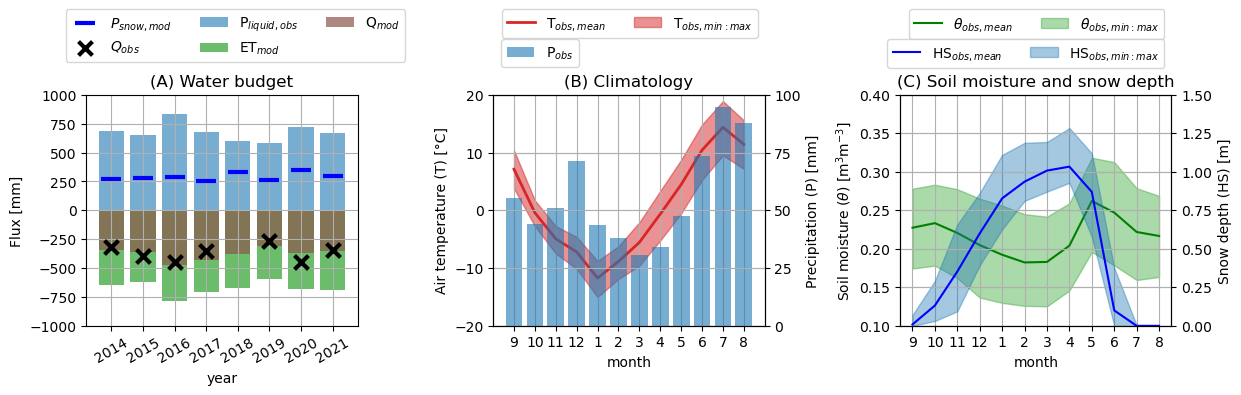

In [5]:
# Plotting water budget and climatology
#wbdf2dy['Qobs'] = wbdf2dy['Qobs'].fillna(-999)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,3));
ax0 = axs[0]
ax1 = axs[1]
ax2 = axs[2]

ax1b = ax1.twinx()
ax1.plot(monthly_clim['T'], color='tab:red', linewidth=2, label=r'T$_{obs,mean}$',zorder=5)
ax1b.bar(monthly_clim.index, monthly_clim['P'], alpha=0.6, label='P$_{obs}$',zorder=0)
ax1.fill_between(monthly_clim.index, monthly_clim['Tmin'], monthly_clim['Tmax'],
                 color='tab:red', alpha=0.5, label=r'T$_{obs,min:max}$',zorder=1)
#ax0.plot(monthly_clim.index, monthly_clim['R']/10, color='tab:orange', alpha=0.4)
ax1.legend(ncol=5,bbox_to_anchor=(1, 1.4))
ax1.set_xlabel('month')
ax1b.legend(ncol=5,bbox_to_anchor=(0.34, 1.27))

#ax0c = ax0.twinx()
#ax0c.stackplot(monthly_clim.index, monthly_clim['R'], colors='tab:orange', alpha=0.3)

for i in range(len(wbdf2dy)):
    ax0.bar(str(wbdf2dy.index[i].year), wbdf2dy['P'][i], alpha=0.6, color='tab:blue', label=r'P$_{liquid,obs}$')
    ax0.bar(str(wbdf2dy.index[i].year), - wbdf2dy['ETmod'][i] - wbdf2dy['Qmod'][i], color='tab:green', alpha=0.7, label=r'ET$_{mod}$')
    ax0.bar(str(wbdf2dy.index[i].year), - wbdf2dy['Qmod'][i], alpha=0.7, color='tab:brown', label=r'Q$_{mod}$')
    ax0.scatter(str(wbdf2dy.index[i].year), wbdf2dy['SWE'][i], s=200, marker='_', color='b', linewidth=3, zorder=2, label=r'$P_{snow,mod}$')
    if np.isfinite(wbdf2dy['Qobs'][i]):
        ax0.scatter(str(wbdf2dy.index[i].year), - wbdf2dy['Qobs'][i], s=100, marker='x', color='k', linewidth=3, zorder=2, label=r'$Q_{obs}$')
    ax0.set_ylim(-1000, 1000)
    if i == 0:
        ax0.legend(ncol=3,bbox_to_anchor=(1.2, 1.4))

ax0.xaxis.set_tick_params(rotation=30)
ax0.set_xlabel('year')

ax2.plot(theta_monthly.index, theta_monthly['mean'], color='green', label=r'$\theta_{obs,mean}$')
ax2.fill_between(theta_monthly.index, theta_monthly['min'], theta_monthly['max'], color='tab:green', alpha=0.4, label=r'$\theta_{obs,min:max}$')
#theta['max'].groupby(theta.index.month).mean().plot()
ax2b = ax2.twinx()
ax2b.plot(monthly_clim['HN']/100, color='blue',zorder=2, label='HS$_{obs,mean}$')
ax2b.fill_between(monthly_clim.index, monthly_clim['HN_min']/100, monthly_clim['HN_max']/100, color='tab:blue', alpha=0.4, label=r'HS$_{obs,min:max}$')
ax2.legend(ncol=3,bbox_to_anchor=(1., 1.4)) 
ax2b.legend(ncol=3,bbox_to_anchor=(1., 1.27)) 
ax2.set_xlabel('month')

#ax0.set_ylim([-20,20])
#ax1.yaxis.tick_right()
#ax1.yaxis.set_label_position("right")

ax1.set_yticks(np.arange(-20, 21, 10))
ax1b.set_yticks(np.arange(0, 101, 25))
ax1.set_ylabel(f'Air temperature (T) [{degree_sign}C]')
ax1b.set_ylabel('Precipitation (P) [mm]')

ax0.set_ylabel('Flux [mm]')

ax2b.set_ylim([0,1])
ax2.set_ylim([0.15,0.35])
ax2b.set_ylim([0,1.25])

ax1.set_ylim([-20,20])
ax1b.set_ylim([0,100])

#ax2.set_yticks(np.arange(0.1, 0.36, 0.05))
#ax2b.set_yticks(np.arange(0.0, 1.26, 0.25))

ax2.set_yticks(np.arange(0.1, 0.41, 0.05))
ax2b.set_yticks(np.arange(0.0, 1.51, 0.25))

ax2.set_ylabel(r'Soil moisture ($\theta$) [m$^3$m$^{-3}$]')
ax2b.set_ylabel(r'Snow depth (HS) [m]')

ax0.set_title('(A) Water budget')
ax1.set_title('(B) Climatology')
ax2.set_title('(C) Soil moisture and snow depth')

plt.subplots_adjust(wspace=0.5, hspace=0)

if saveplots == True:
        plt.savefig(f'clima_and_water_{today}.pdf',bbox_inches='tight', dpi=300)
        plt.savefig(f'clima_and_water_{today}.png',bbox_inches='tight', dpi=300)

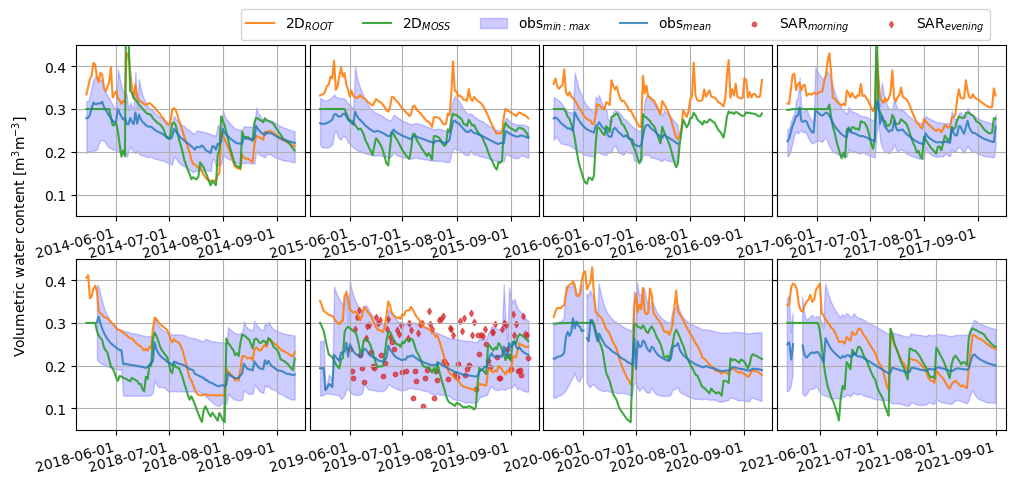

In [5]:
# TEMPORAL SOIL MOISTURE ET HILLTOP (KENTTÄROVA)
# Plotting
start_day = pd.to_datetime('2019-06-01')
end_day = pd.to_datetime('2019-09-11')
window = pd.date_range(start_day, end_day, freq='D')

#period = pd.date_range('2014-04-01', '2021-09-01', freq='D')
window_sar = window[window.isin(dates_sar_m)]
window_sar2 = window[window.isin(dates_sar_e)]

ylims = [0.1,0.47]
###
fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(2, 4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(len(axes)):
    start = str(years[i])+str('-05-15')
    june = str(years[i])+str('-06-01')
    if years[i] == 2021:
        end = str(years[i])+str('-09-01')
    else:
        end = str(years[i])+str('-09-11')
    period = pd.date_range(start, end, freq='D')
    #res_top['bucket_moisture_root'].sel(time=slice(start, end))[:,ht[0],ht[1]].plot(ax=axes[i], color='tab:green', alpha=0.9, label='TOP')
    #res_1d['bucket_moisture_root'].sel(time=slice(start, end))[:,ht[0],ht[1]].plot(ax=axes[i], color='tab:orange', alpha=0.9, label='1D')
    res_1d['bucket_moisture_root'].sel(time=slice(start, end))[:,ht[0],ht[1]].plot(ax=axes[i], color='tab:orange', alpha=0.9, label='2D$_{ROOT}$')
    res_1d['bucket_moisture_top'].sel(time=slice(start, end))[:,ht[0],ht[1]].plot(ax=axes[i], color='tab:green', alpha=0.9, label='2D$_{MOSS}$')
    axes[i].fill_between(period, theta.loc[period, 'min'], theta.loc[period, 'max'], color='blue', alpha=0.2, label=r'obs$_{min:max}$')
    axes[i].plot(period, theta.loc[period, 'mean_obs'], color='tab:blue', alpha=0.8, label=r'obs$_{mean}$')
    #theta.loc[period, 'mean_obs'].plot(color='k', alpha=0.5, label=r'mean$_{obs}$')
    if (i == 0) | (i == 4): 
        axes[i].set_ylabel(r'')
    else:
        axes[i].axes.get_yaxis().set_ticklabels([])
        axes[i].set_ylabel('')
    axes[i].set_ylim(0.05,0.45)
    #axes[i].set_ylim(0.05,0.7)
    axes[i].set_title('')
    #axes[i].set_xticks(np.arange())
    axes[i].set_xlabel('')
    axes[i].set_xticks(pd.date_range(june, end, freq='MS'))
    axes[i].xaxis.set_tick_params(rotation=15)

ax6.scatter(window_sar, sar_m['theta'].sel(time=window_sar)[:,ht[0], ht[1]], marker='o', s=10, alpha=0.7, color='tab:red', label='SAR$_{morning}$')
ax6.scatter(window_sar2, sar_e['theta'].sel(time=window_sar2)[:,ht[0], ht[1]], s=10, color='tab:red', marker='d', alpha=0.7, label='SAR$_{evening}$')
    
#ax1.legend(ncol=5, bbox_to_anchor=(2.6,1.25))
ax6.legend(ncol=7, bbox_to_anchor=(3,2.5))

fig.text(0.07, 0.5, 'Volumetric water content [m$^3$m$^{-3}]$', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.02, hspace=0.25)

if saveplots == True:
        plt.savefig(f'theta_temp_{today}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'theta_temp_{today}.png', bbox_inches='tight', dpi=300)

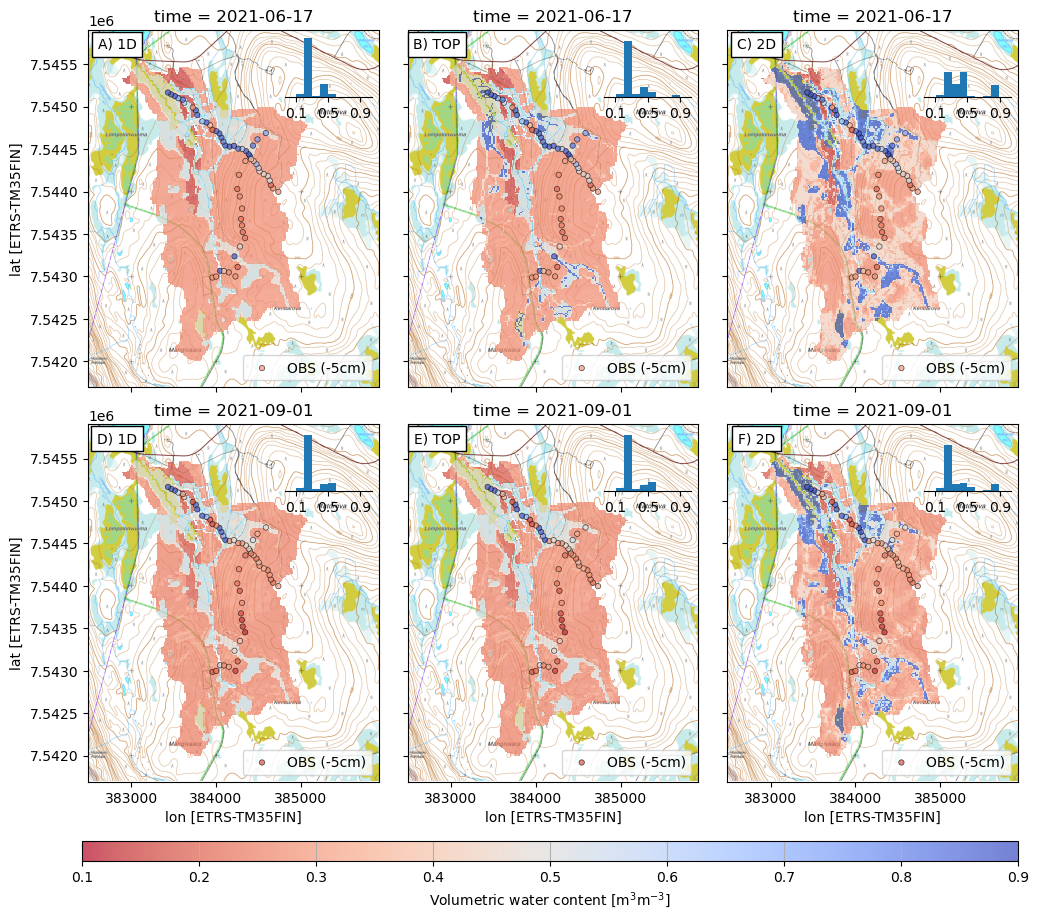

In [31]:
# SPAFHY SPATIAL MODEL VERSION COMPARISON WET AND DRY DAY

lims = [0.01,0.99]
bins = 10
ms = 15

start = np.where(pd.to_datetime(dates_spa) == '2021-05-01')[0][0]
end = np.where(pd.to_datetime(dates_spa) == '2021-09-01')[0][0]

d1 = '2021-06-17'
doi1 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d1)[0][0]
doi_m1 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d1)[0][0]
d2 = '2021-09-01'
doi2 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d2)[0][0]
doi_m2 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d2)[0][0]

alp=0.7
ylims = [0.1,0.9]
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

rasterio.plot.show(pk, transform=meta['transform'], ax=ax1);
im1 = res_1d['bucket_moisture_root'][start:end][doi1].plot(ax=ax1, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d1,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax1, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')
ix1 = inset_axes(ax1,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix1.hist(res_1d['bucket_moisture_root'][start:end][doi1].values.flatten()[~np.isnan(res_1d['bucket_moisture_root'][start:end][doi1].values.flatten())], bins=bins, range=lims)
ix1.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
#im1 = ax2.imshow(results_catch['bucket_moisture_root'][start:end][maxd], cmap='coolwarm_r', vmin=0.1, vmax=0.88
im2 = res_top['bucket_moisture_root'][start:end][doi1].plot(ax=ax2, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d1,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax2, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')

ix2 = inset_axes(ax2,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix2.hist(res_top['bucket_moisture_root'][start:end][doi1].values.flatten()[~np.isnan(res_top['bucket_moisture_root'][start:end][doi1].values.flatten())], bins=bins, range=lims)
ix2.patch.set_alpha(0.01)

    
rasterio.plot.show(pk, transform=meta['transform'], ax=ax3)

(res_2d['bucket_moisture_root'][start:end][doi1]*dmask).plot(ax=ax3, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                    add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d1,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax3, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')
                                              #theta_spat_gpd.loc[theta_spat_gpd.index == d][['SM_mean', 'geometry']].plot()

ix3 = inset_axes(ax3,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix3.hist((res_2d['bucket_moisture_root'][start:end][doi1]*dmask).values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end][doi1].values.flatten())], bins=bins, range=lims)
ix3.patch.set_alpha(0.01)


rasterio.plot.show(pk, transform=meta['transform'], ax=ax4);
im4 = res_1d['bucket_moisture_root'][start:end+1][doi2].plot(ax=ax4, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d2,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax4, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')

ix4 = inset_axes(ax4,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix4.hist(res_1d['bucket_moisture_root'][start:end+1][doi2].values.flatten()[~np.isnan(res_1d['bucket_moisture_root'][start:end+1][doi2].values.flatten())], bins=bins, range=lims)
ix4.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax5);
#im1 = ax2.imshow(results_catch['bucket_moisture_root'][start:end][maxd], cmap='coolwarm_r', vmin=0.1, vmax=0.88)
im5 = res_top['bucket_moisture_root'][start:end+1][doi2].plot(ax=ax5, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d2,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax5, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')
ix5 = inset_axes(ax5,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix5.hist(res_top['bucket_moisture_root'][start:end+1][doi2].values.flatten()[~np.isnan(res_top['bucket_moisture_root'][start:end+1][doi2].values.flatten())], bins=bins, range=lims)
ix5.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax6)

(res_2d['bucket_moisture_root'][start:end+1][doi2]*dmask).plot(ax=ax6, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                    add_colorbar=False)
theta_spat_gpd.loc[theta_spat_gpd.index == d2,
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax6, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-5cm)')
# TEST to see all locations
#theta_spat_gpd.loc[(theta_spat_gpd.index != d1) & (theta_spat_gpd.index != d2)][['theta', 'geometry']].plot(column='theta',
#                                               ax=ax6, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
#                                              markersize=25,
#                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')
                                              #theta_spat_gpd.loc[theta_spat_gpd.index == d][['SM_mean', 'geometry']].plot()
ix6 = inset_axes(ax6,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix6.hist((res_2d['bucket_moisture_root'][start:end+1][doi2]*dmask).values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end+1][doi2].values.flatten())], bins=bins, range=lims)
ix6.patch.set_alpha(0.01)


props = dict(facecolor='white', alpha=1)

ax1.text(0.1, 0.96,'A) 1D', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     bbox=props)
ax2.text(0.1, 0.96,'B) TOP', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     bbox=props)
ax3.text(0.1, 0.96,'C) 2D', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes,
     bbox=props)

ax4.text(0.1, 0.96,'D) 1D', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes,
     bbox=props)
ax5.text(0.1, 0.96,'E) TOP', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes,
     bbox=props)
ax6.text(0.1, 0.96,'F) 2D', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes,
     bbox=props)

ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')

ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xlabel('')
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_xlabel('')
ax3.axes.get_xaxis().set_ticklabels([])
ax3.set_xlabel('')

ax5.axes.get_yaxis().set_ticklabels([])
ax5.set_ylabel('')
ax6.axes.get_yaxis().set_ticklabels([])
ax6.set_ylabel('')

ix1.axes.get_yaxis().set_ticklabels([])
ix2.axes.get_yaxis().set_ticklabels([])
ix3.axes.get_yaxis().set_ticklabels([])
ix4.axes.get_yaxis().set_ticklabels([])
ix5.axes.get_yaxis().set_ticklabels([])
ix6.axes.get_yaxis().set_ticklabels([])

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')
ax5.legend(loc='lower right')
ax6.legend(loc='lower right')

ix1.set_yticks([])
ix2.set_yticks([])
ix3.set_yticks([])
ix4.set_yticks([])
ix5.set_yticks([])
ix6.set_yticks([])

ix1.set_xticks([])
ix2.set_xticks([])
ix3.set_xticks([])
ix4.set_xticks([])
ix5.set_xticks([])
ix6.set_xticks([])

ix1.set_ylim([0,12000])
ix2.set_ylim([0,12000])
ix3.set_ylim([0,12000])
ix4.set_ylim([0,12000])
ix5.set_ylim([0,12000])
ix6.set_ylim([0,12000])

ix1.set_xticks(np.arange(0.1,1.01,0.4))
ix2.set_xticks(np.arange(0.1,1.01,0.4))
ix3.set_xticks(np.arange(0.1,1.01,0.4))
ix4.set_xticks(np.arange(0.1,1.01,0.4))
ix5.set_xticks(np.arange(0.1,1.01,0.4))
ix6.set_xticks(np.arange(0.1,1.01,0.4))

ix1.spines[['right', 'top', 'left']].set_visible(False)
ix2.spines[['right', 'top', 'left']].set_visible(False)
ix3.spines[['right', 'top', 'left']].set_visible(False)
ix4.spines[['right', 'top', 'left']].set_visible(False)
ix5.spines[['right', 'top', 'left']].set_visible(False)
ix6.spines[['right', 'top', 'left']].set_visible(False)

ix1.grid(False)
ix2.grid(False)
ix3.grid(False)
ix4.grid(False)
ix5.grid(False)
ix6.grid(False)

cax = plt.axes([0.12, 0.04, 0.78, 0.02])
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label(r'Volumetric water content [m$^3$m$^{-3}$]')

plt.subplots_adjust(wspace=0.1, hspace=0.05)

plt.savefig(f'spatial_models_2021_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_models_2021_{today}.png', bbox_inches='tight', dpi=300)

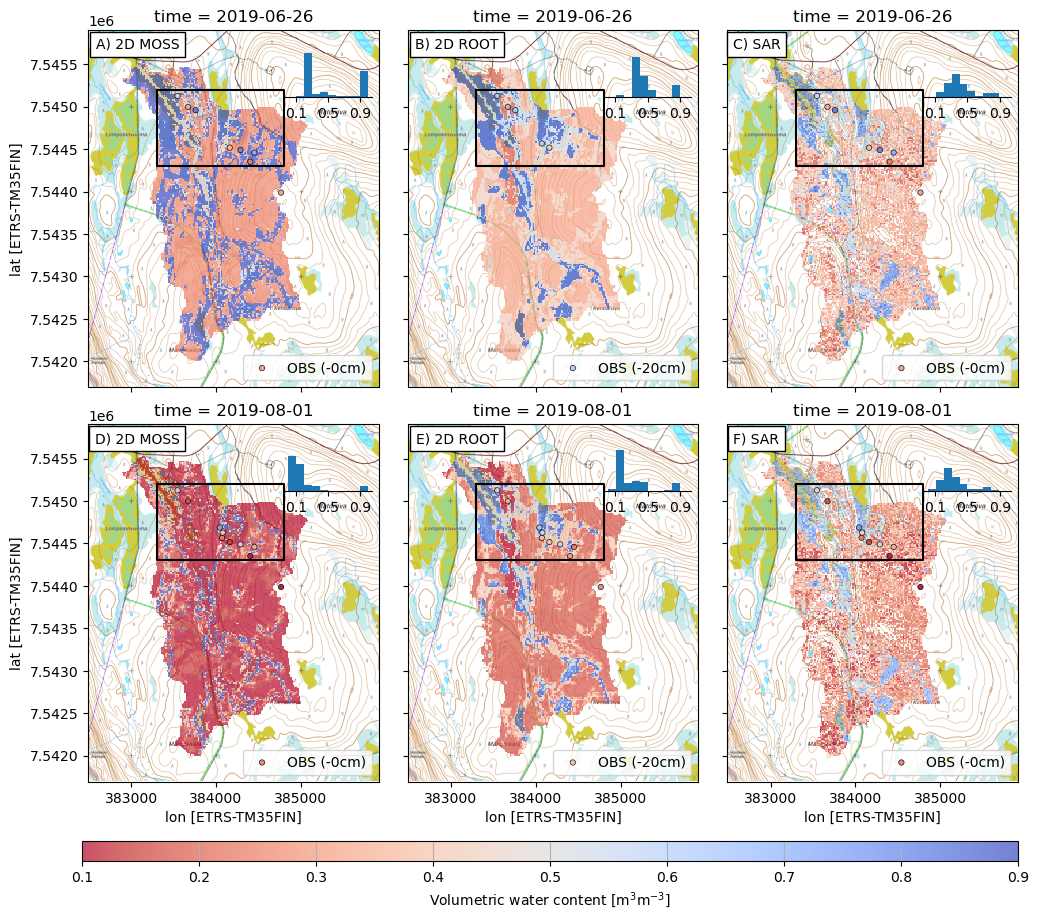

In [30]:
# SPAFHY SPATIAL MODEL VERSION COMPARISON WET AND DRY DAY

from shapely import Point
lims = [0.01,0.99]
bins = 10
ms = 15

start = np.where(pd.to_datetime(dates_spa) == '2019-05-01')[0][0]
end = np.where(pd.to_datetime(dates_spa) == '2019-09-01')[0][0]

d1 = '2019-06-26' # 06-26 or 06-01
doi1 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d1)[0][0]
doi_m1 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d1)[0][0]
d2 = '2019-08-01'
doi2 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d2)[0][0]
doi_m2 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d2)[0][0]

d1_meas = theta_spat_gpd.loc[theta_spat_gpd.index == d1].groupby('ID_i').mean(numeric_only=True)
d1_meas['geometry'] = np.nan
for i in d1_meas.index:
    d1_meas.loc[d1_meas.index == i, 'geometry'] = Point(theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].x, theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].y)
    
d2_meas = theta_spat_gpd.loc[theta_spat_gpd.index == d2].groupby('ID_i').mean(numeric_only=True)
d2_meas['geometry'] = np.nan
for i in d1_meas.index:
    d2_meas.loc[d2_meas.index == i, 'geometry'] = Point(theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].x, theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].y)

    
bbox = [7.5452e6, 7.5443e6, 383300, 384800]

xs = [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]]
ys = [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]]
    
d1_meas = gpd.GeoDataFrame(d1_meas)
d2_meas = gpd.GeoDataFrame(d2_meas)

alp = 0.7
alp2 = 0.9
ylims = [0.1,0.9]
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])


rasterio.plot.show(pk, transform=meta['transform'], ax=ax1);
im1 = res_2d['bucket_moisture_top'][start:end][doi1].plot(ax=ax1, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 0)].plot(column='theta',
                                               ax=ax1, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp2, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')

ix1 = inset_axes(ax1,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix1.hist(res_2d['bucket_moisture_top'][start:end][doi1].values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end][doi1].values.flatten())], bins=bins, range=lims)
ix1.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax2);
#im1 = ax2.imshow(results_catch['bucket_moisture_root'][start:end][maxd], cmap='coolwarm_r', vmin=0.1, vmax=0.88
im2 = res_2d['bucket_moisture_root'][start:end][doi1].plot(ax=ax2, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 20)].plot(column='theta',
                                               ax=ax2, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp2, vmin=ylims[0], vmax=ylims[1], label='OBS (-20cm)')


ix2 = inset_axes(ax2,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix2.hist(res_2d['bucket_moisture_root'][start:end][doi1].values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end][doi1].values.flatten())], bins=bins, range=lims)
ix2.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax3)

im3 = (sar_m['theta'].sel(time=d1)*dmask).plot(ax=ax3, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)
#theta_spat_gpd.loc[theta_spat_gpd.index == d1,
#                   ['theta', 'geometry']].plot(column='theta',
#                                               ax=ax3, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
#                                               markersize=ms,
#                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS')

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 0)].plot(column='theta',
                                               ax=ax3, cmap='coolwarm_r', edgecolor='black', linewidth=0.5,
                                               markersize=ms,
                                               alpha=alp2, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')

ix3 = inset_axes(ax3,
                    width="30%", # width = 30% of parent_bbox
                    height=0.6, # height : 1 inch
                    loc=1)
ix3.hist((sar_m['theta'].sel(time=d1)*dmask).values.flatten()[~np.isnan(sar_m['theta'].sel(time=d1)*dmask).values.flatten()], bins=bins, range=lims)
ix3.patch.set_alpha(0.01)


rasterio.plot.show(pk, transform=meta['transform'], ax=ax4)
im4 = res_2d['bucket_moisture_top'][start:end+1][doi2].plot(ax=ax4, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 0)].plot(
    column='theta', ax=ax4, cmap='coolwarm_r', edgecolor='black', linewidth=0.5, markersize=ms, 
    alpha=alp2, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')


ix4 = inset_axes(ax4, width="30%", height=0.6,loc=1)
ix4.hist(res_2d['bucket_moisture_top'][start:end+1][doi2].values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end+1][doi2].values.flatten())], bins=bins, range=lims)
ix4.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax5);
#im1 = ax2.imshow(results_catch['bucket_moisture_root'][start:end][maxd], cmap='coolwarm_r', vmin=0.1, vmax=0.88)
im5 = res_2d['bucket_moisture_root'][start:end+1][doi2].plot(ax=ax5, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 20)].plot(
    column='theta', ax=ax5, cmap='coolwarm_r', edgecolor='black', linewidth=0.5, markersize=ms,alpha=alp2,
    vmin=ylims[0], vmax=ylims[1], label='OBS (-20cm)')

ix5 = inset_axes(ax5,width="30%", height=0.6, loc=1)
ix5.hist(res_2d['bucket_moisture_root'][start:end+1][doi2].values.flatten()[~np.isnan(res_2d['bucket_moisture_root'][start:end+1][doi2].values.flatten())], bins=bins, range=lims)
ix5.patch.set_alpha(0.01)

rasterio.plot.show(pk, transform=meta['transform'], ax=ax6)

im6 = (sar_m['theta'].sel(time=d2)*dmask).plot(ax=ax6, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 0)].plot(
    column='theta',ax=ax6, cmap='coolwarm_r', edgecolor='black', linewidth=0.5, markersize=ms, 
    alpha=alp2, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')
ix6 = inset_axes(ax6,width="30%", height=0.6, loc=1)
ix6.hist((sar_m['theta'].sel(time=d2)*dmask).values.flatten()[~np.isnan((sar_m['theta'].sel(time=d2)*dmask).values.flatten())], bins=bins, range=lims)
                                                              
ix6.patch.set_alpha(0.01)

props = dict(facecolor='white', alpha=1)

ax1.text(0.17, 0.96,'A) 2D MOSS', size=10,horizontalalignment='center',verticalalignment='center',transform = ax1.transAxes, bbox=props)
ax2.text(0.17, 0.96,'B) 2D ROOT', size=10,horizontalalignment='center',verticalalignment='center',transform = ax2.transAxes,bbox=props)
ax3.text(0.1, 0.96,'C) SAR', size=10,horizontalalignment='center',verticalalignment='center', transform = ax3.transAxes,bbox=props)

ax4.text(0.17, 0.96,'D) 2D MOSS', size=10,horizontalalignment='center', verticalalignment='center',transform = ax4.transAxes, bbox=props)
ax5.text(0.17, 0.96,'E) 2D ROOT', size=10,horizontalalignment='center',verticalalignment='center',transform = ax5.transAxes, bbox=props)
ax6.text(0.1, 0.96,'F) SAR', size=10,horizontalalignment='center', verticalalignment='center',transform = ax6.transAxes, bbox=props)

ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')

ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xlabel('')
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_xlabel('')
ax3.axes.get_xaxis().set_ticklabels([])
ax3.set_xlabel('')

ax5.axes.get_yaxis().set_ticklabels([])
ax5.set_ylabel('')
ax6.axes.get_yaxis().set_ticklabels([])
ax6.set_ylabel('')

ix1.axes.get_yaxis().set_ticklabels([])
ix2.axes.get_yaxis().set_ticklabels([])
ix3.axes.get_yaxis().set_ticklabels([])
ix4.axes.get_yaxis().set_ticklabels([])
ix5.axes.get_yaxis().set_ticklabels([])
ix6.axes.get_yaxis().set_ticklabels([])


ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')
ax5.legend(loc='lower right')
ax6.legend(loc='lower right')

ix1.set_yticks([])
ix2.set_yticks([])
ix3.set_yticks([])
ix4.set_yticks([])
ix5.set_yticks([])
ix6.set_yticks([])

ix1.set_xticks([])
ix2.set_xticks([])
ix3.set_xticks([])
ix4.set_xticks([])
ix5.set_xticks([])
ix6.set_xticks([])

ix1.set_ylim([0,12000])
ix2.set_ylim([0,12000])
ix3.set_ylim([0,12000])
ix4.set_ylim([0,12000])
ix5.set_ylim([0,12000])
ix6.set_ylim([0,12000])


ix1.set_xticks(np.arange(0.1,1.01,0.4))
ix2.set_xticks(np.arange(0.1,1.01,0.4))
ix3.set_xticks(np.arange(0.1,1.01,0.4))
ix4.set_xticks(np.arange(0.1,1.01,0.4))
ix5.set_xticks(np.arange(0.1,1.01,0.4))
ix6.set_xticks(np.arange(0.1,1.01,0.4))

ax1.plot(xs, ys, color="black")
ax2.plot(xs, ys, color="black")
ax3.plot(xs, ys, color="black")
ax4.plot(xs, ys, color="black")
ax5.plot(xs, ys, color="black")
ax6.plot(xs, ys, color="black")

ix1.spines[['right', 'top', 'left']].set_visible(False)
ix2.spines[['right', 'top', 'left']].set_visible(False)
ix3.spines[['right', 'top', 'left']].set_visible(False)
ix4.spines[['right', 'top', 'left']].set_visible(False)
ix5.spines[['right', 'top', 'left']].set_visible(False)
ix6.spines[['right', 'top', 'left']].set_visible(False)

ix1.grid(False)
ix2.grid(False)
ix3.grid(False)
ix4.grid(False)
ix5.grid(False)
ix6.grid(False)

cax = plt.axes([0.12, 0.04, 0.78, 0.02])
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label(r'Volumetric water content [m$^3$m$^{-3}$]')

plt.subplots_adjust(wspace=0.1, hspace=0.05)

plt.savefig(f'spatial_2d_sar_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_2d_sar_{today}.png', bbox_inches='tight', dpi=300)

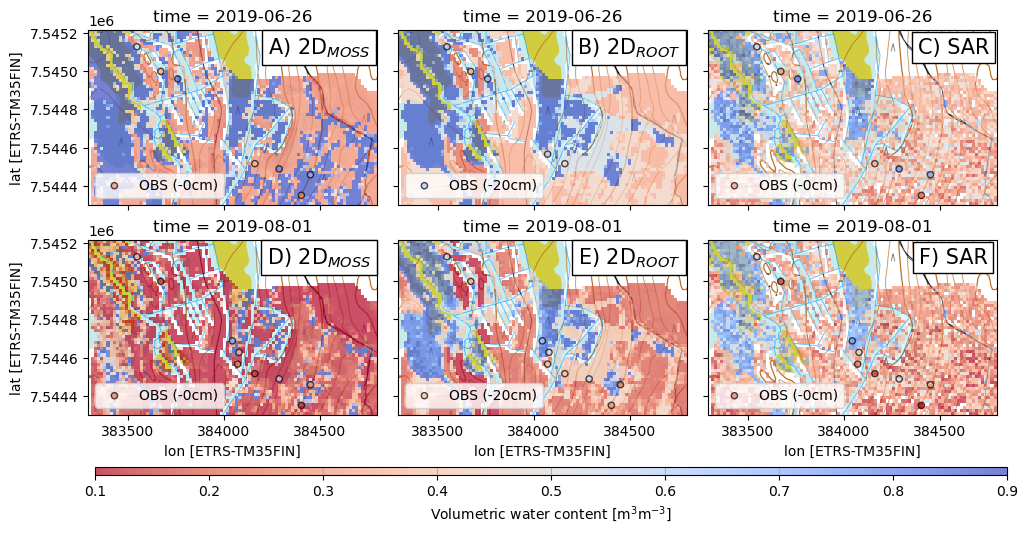

In [29]:
# SPATIAL COMPARISON 2D and SAR

import matplotlib.patches as patches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

start = np.where(pd.to_datetime(dates_spa) == '2019-05-01')[0][0]
end = np.where(pd.to_datetime(dates_spa) == '2019-09-01')[0][0]

d1 = '2019-06-26' # 06-26 or 06-01
doi1 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d1)[0][0]
doi_m1 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d1)[0][0]
d2 = '2019-08-01'
doi2 = np.where(pd.to_datetime(dates_spa[start:end+1]) == d2)[0][0]
doi_m2 = np.where(pd.to_datetime(theta_spat['time'][:].data) == d2)[0][0]

d1_meas = theta_spat_gpd.loc[theta_spat_gpd.index == d1].groupby('ID_i').mean(numeric_only=True)
d1_meas['geometry'] = np.nan
for i in d1_meas.index:
    d1_meas.loc[d1_meas.index == i, 'geometry'] = Point(theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].x, theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].y)
    
d2_meas = theta_spat_gpd.loc[theta_spat_gpd.index == d2].groupby('ID_i').mean(numeric_only=True)
d2_meas['geometry'] = np.nan
for i in d1_meas.index:
    d2_meas.loc[d2_meas.index == i, 'geometry'] = Point(theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].x, theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == i]['geometry'][0].y)


sar_wet_day = np.where(np.nansum(sar_m['theta'], axis=(1,2)) == np.nansum(sar_m['theta'], axis=(1,2)).max())
sar_dry_day = np.where(np.nansum(sar_m['theta'], axis=(1,2)) == np.nansum(sar_m['theta'], axis=(1,2)).min())

wet_day = pd.to_datetime(sar_m['time'][sar_wet_day].data[0])
dry_day = pd.to_datetime(sar_m['time'][sar_dry_day].data[0])

doi = np.where(pd.to_datetime(dates_spa[start:end]) == wet_day)[0][0]
d = pd.to_datetime(wet_day)

lims = [0.01,0.99]
bins = 10
ms = 20
ms2 = 30

bbox = [7.5452e6, 7.5443e6, 383300, 384800]
bbox_id = [np.where(res_1d['lat'] == find_nearest(res_1d['lat'],bbox[0]))[0][0],
           np.where(res_1d['lat'] == find_nearest(res_1d['lat'],bbox[1]))[0][0],
           np.where(res_1d['lon'] == find_nearest(res_1d['lon'],bbox[2]))[0][0],
           np.where(res_1d['lon'] == find_nearest(res_1d['lon'],bbox[3]))[0][0]]
xs = [bbox[2], bbox[3], bbox[3], bbox[2], bbox[2]]
ys = [bbox[0], bbox[0], bbox[1], bbox[1], bbox[0]]

props = dict(facecolor='white', alpha=1)


alp=0.7
ylims = [0.1,0.9]
ylimstemp = [0.08,0.5]
fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(2,3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

## dates 1 ###

# 2D top
rasterio.plot.show(pk, transform=meta['transform'], ax=ax1)
im1 = (res_2d['bucket_moisture_top'][start:end].sel(time=d1)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax1, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 0),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax1, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')


# 2D root
rasterio.plot.show(pk, transform=meta['transform'], ax=ax2)
im2 = (res_2d['bucket_moisture_root'][start:end].sel(time=d1)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax2, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 20),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax2, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-20cm)')
                                               
# SAR                                               
rasterio.plot.show(pk, transform=meta['transform'], ax=ax3);
im3 = (sar_m['theta'].sel(time=d1)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax3, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d1) & (theta_spat_gpd['z'] == 0),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax3, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')

## dates 2 ###

# 2D top
rasterio.plot.show(pk, transform=meta['transform'], ax=ax4)
im4 = (res_2d['bucket_moisture_top'][start:end].sel(time=d2)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax4, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 0),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax4, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')
# 2D root
rasterio.plot.show(pk, transform=meta['transform'], ax=ax5)
im5 = (res_2d['bucket_moisture_root'][start:end].sel(time=d2)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax5, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 20),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax5, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-20cm)')
                                               
# SAR                                         
rasterio.plot.show(pk, transform=meta['transform'], ax=ax6);
im6 = (sar_m['theta'].sel(time=d2)*dmask)[bbox_id[0]:bbox_id[1],bbox_id[2]:bbox_id[3]].plot(ax=ax6, cmap='coolwarm_r', vmin=ylims[0], vmax=ylims[1], alpha=alp,
                                                          add_colorbar=False)

theta_spat_gpd.loc[(theta_spat_gpd.index == d2) & (theta_spat_gpd['z'] == 0),
                   ['theta', 'geometry']].plot(column='theta',
                                               ax=ax6, cmap='coolwarm_r', edgecolor='black', linewidth=1,
                                               markersize=ms,
                                               alpha=alp, vmin=ylims[0], vmax=ylims[1], label='OBS (-0cm)')


ax1.text(0.8, 0.9,r'A) 2D$_{MOSS}$', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     bbox=props)

ax2.text(0.8, 0.9,r'B) 2D$_{ROOT}$', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     bbox=props)

ax3.text(0.85, 0.9,'C) SAR', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes,
     bbox=props)

ax4.text(0.8, 0.9,r'D) 2D$_{MOSS}$', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes,
     bbox=props)

ax5.text(0.8, 0.9,r'E) 2D$_{ROOT}$', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes,
     bbox=props)

ax6.text(0.85, 0.9,'F) SAR', size=15,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes,
     bbox=props)

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')
ax3.legend(loc='lower left')
ax4.legend(loc='lower left')
ax5.legend(loc='lower left')
ax6.legend(loc='lower left')

ax2.set_ylabel('')
ax3.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')

ax2.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax5.axes.get_yaxis().set_ticklabels([])
ax6.axes.get_yaxis().set_ticklabels([])

ax1.axes.get_xaxis().set_ticklabels([])
ax2.axes.get_xaxis().set_ticklabels([])
ax3.axes.get_xaxis().set_ticklabels([])
#ax3.axes.get_xaxis().set_ticks([])

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

cax = plt.axes([0.14, -0.01, 0.76, 0.015]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label('Volumetric water content [m$^3$m$^{-3}$]')

plt.subplots_adjust(wspace=0.0, hspace=0.2)

#plt.savefig(f'spatial_2d_sar_zoom_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_2d_sar_zoom{today}.png', bbox_inches='tight', dpi=300)

In [12]:
# mean differences!

# root
q1_2_1 = str(round((res_2d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True).mean().data),3))
q5_2_1 = str(round((res_2d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True).mean().data),3))
q9_2_1 = str(round((res_2d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True).mean().data),3))

q1_1_1 = str(round((res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True).mean().data),3))
q5_1_1 = str(round((res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True).mean().data),3))
q9_1_1 = str(round((res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True).mean().data),3))

# moss
q1m_2_1 = str(round((res_2d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True).mean().data),3))
q5m_2_1 = str(round((res_2d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True).mean().data),3))
q9m_2_1 = str(round((res_2d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True).mean().data -
      res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True).mean().data),3))

q1m_1_1 = str(round((res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True).mean().data),3))
q5m_1_1 = str(round((res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True).mean().data),3))
q9m_1_1 = str(round((res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True).mean().data -
      res_1d_ave['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True).mean().data),3))

C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1

C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1

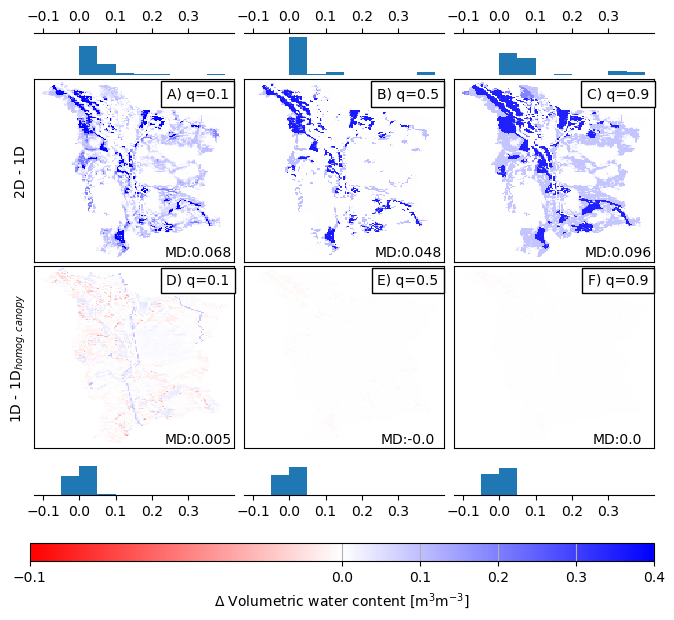

In [26]:
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
from matplotlib.colors import TwoSlopeNorm

lims = [-0.1,0.4]
bins = 10

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))
z = np.linspace(-0.1,0.4,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max())
my_cmap='bwr_r'

# Choose colormap
#cmap = pl.cm.Oranges

# Get the colormap colors
#my_cmap = cmap(np.arange(cmap.N))

# Set alpha
#my_cmap[:,-1] = np.linspace(0.2, 0.9, cmap.N)
# Create new colormap
#my_cmap = ListedColormap(my_cmap)

#my_cmap = 'gist_heat_r'

#ixs = [ix1, ix2, ix3, ix4]
#axs = [ax1, ax2, ax3, ax4]

alp=0.7
ylims = [-0.1,0.4]
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(10, 3)

ax1 = fig.add_subplot(gs[1:5, 0])
ax2 = fig.add_subplot(gs[1:5, 1])
ax3 = fig.add_subplot(gs[1:5, 2])

ix1 =  fig.add_subplot(gs[0, 0])
ix2 =  fig.add_subplot(gs[0, 1])
ix3 =  fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[5:9, 0])
ax5 = fig.add_subplot(gs[5:9, 1])
ax6 = fig.add_subplot(gs[5:9, 2])

ix4 = fig.add_subplot(gs[9, 0])
ix5 = fig.add_subplot(gs[9, 1])
ix6 = fig.add_subplot(gs[9, 2])

# ax1: 2d - 1d: 0.1
im1 = (res_2d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)-res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax1, cmap=my_cmap, norm=norm, vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')

#ix1 = inset_axes(ax1,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix1.hist((res_2d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)
          -res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)-
                                                                                                              res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix1.patch.set_alpha(0.01)

# ax4: 1d - 1d ave: 0.1
im4 = (res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)
       -res_1d_ave['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax4, cmap=my_cmap,  norm=norm, vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')

ix4.hist((res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)
          -res_1d_ave['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)-
                                                                                                                  res_1d_ave['bucket_moisture_root'].quantile(0.1, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix4.patch.set_alpha(0.01)

# ax2: 2d - 1d: 0.5
(res_2d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
 -res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax2, cmap=my_cmap, norm=norm,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')
#ix3 = inset_axes(ax3,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix2.hist((res_2d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
          -res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
                                                                                                 -res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix2.patch.set_alpha(0.01)

# ax5: 1d - 1d ave: 0.5
(res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
 -res_1d_ave['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax5, cmap=my_cmap, norm=norm,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')

ix5.hist((res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
          -res_1d_ave['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)
                                                                                                     -res_1d_ave['bucket_moisture_root'].quantile(0.5, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix5.patch.set_alpha(0.01)

# ax3: 2d - 1d: 0.9
(res_2d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
 -res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax3, cmap=my_cmap, norm=norm,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')
#ix5 = inset_axes(ax5,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix3.hist((res_2d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
          -res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
                                                                                                 -res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix3.patch.set_alpha(0.01)

# ax6: 1d - 1d ave: 0.9
(res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
 -res_1d_ave['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax6, cmap=my_cmap, norm=norm,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D')
ix6.hist((res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
           -res_1d_ave['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)
                                                                                                      -res_1d_ave['bucket_moisture_root'].quantile(0.9, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix6.patch.set_alpha(0.01)

props = dict(facecolor='white', alpha=1)

ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')

ax5.axes.get_yaxis().set_ticklabels([])
ax5.set_ylabel('')
ax6.axes.get_yaxis().set_ticklabels([])
ax6.set_ylabel('')

ax1.text(0.82, 0.92,f'A) q=0.1', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     bbox=props)

ax1.text(0.82, 0.05,f'MD:{q1_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)

ax2.text(0.82, 0.92,f'B) q=0.5', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     bbox=props)

ax2.text(0.82, 0.05,f'MD:{q5_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes)

ax3.text(0.82, 0.92,f'C) q=0.9', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes,
     bbox=props)

ax3.text(0.82, 0.05,f'MD:{q9_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes)

ax4.text(0.82, 0.92,f'D) q=0.1', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes,
     bbox=props)

ax4.text(0.82, 0.05,f'MD:{q1_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes)

ax5.text(0.82, 0.92,f'E) q=0.5', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes,
     bbox=props)

ax5.text(0.82, 0.05,f'MD:{q5_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes)

ax6.text(0.82, 0.92,f'F) q=0.9', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes,
     bbox=props)

ax6.text(0.82, 0.05,f'MD:{q9_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes)

ix1.axes.get_yaxis().set_ticklabels([])
ix2.axes.get_yaxis().set_ticklabels([])
ix3.axes.get_yaxis().set_ticklabels([])

ix4.axes.get_yaxis().set_ticklabels([])
ix5.axes.get_yaxis().set_ticklabels([])
ix6.axes.get_yaxis().set_ticklabels([])

ix1.set_yticks([])
ix2.set_yticks([])
ix3.set_yticks([])

ix4.set_yticks([])
ix5.set_yticks([])
ix6.set_yticks([])

ix1.set_xticks(np.arange(-0.1,0.35,0.1))
ix2.set_xticks(np.arange(-0.1,0.35,0.1))
ix3.set_xticks(np.arange(-0.1,0.35,0.1))
ix4.set_xticks(np.arange(-0.1,0.35,0.1))
ix5.set_xticks(np.arange(-0.1,0.35,0.1))
ix6.set_xticks(np.arange(-0.1,0.35,0.1))


ix1.spines[['right', 'bottom', 'left']].set_visible(False)
ix2.spines[['right', 'bottom', 'left']].set_visible(False)
ix3.spines[['right', 'bottom', 'left']].set_visible(False)
ix4.spines[['right', 'top', 'left']].set_visible(False)
ix5.spines[['right', 'top', 'left']].set_visible(False)
ix6.spines[['right', 'top', 'left']].set_visible(False)

ix1.grid(False)
ix2.grid(False)
ix3.grid(False)
ix4.grid(False)
ix5.grid(False)
ix6.grid(False)

ix1.set_ylim(0,14000)
ix2.set_ylim(0,14000)
ix3.set_ylim(0,14000)
ix4.set_ylim(0,14000)
ix5.set_ylim(0,14000)
ix6.set_ylim(0,14000)


ix1.xaxis.set_label_position('top')
ix1.xaxis.tick_top()
ix2.xaxis.set_label_position('top')
ix2.xaxis.tick_top()
ix3.xaxis.set_label_position('top')
ix3.xaxis.tick_top()

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')

ax1.axes.get_yaxis().set_ticklabels([])
ax1.set_ylabel('')
ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')
ax4.axes.get_yaxis().set_ticklabels([])
ax4.set_ylabel('')
ax4.set_ylabel(r'1D - 1D$_{homog.canopy}$')
ax1.set_ylabel('2D - 1D')

ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xlabel('')
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_xlabel('')
ax3.axes.get_xaxis().set_ticklabels([])
ax3.set_xlabel('')

ax4.axes.get_xaxis().set_ticklabels([])
ax4.set_xlabel('')
ax5.axes.get_xaxis().set_ticklabels([])
ax5.set_xlabel('')
ax6.axes.get_xaxis().set_ticklabels([])
ax6.set_xlabel('')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

cax = plt.axes([0.12, 0, 0.78, 0.03]) #  4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label(u'Δ Volumetric water content [m$^3$m$^{-3}$]')
#plt.title('SpaFHy-2D - SpaFHy-1D', y=2)
#fig.suptitle('SpaFHy-2D - SpaFHy-1D', fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig(f'spatial_models_dif_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_models_dif_{today}.png', bbox_inches='tight', dpi=300)

C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
C:\Users\janousu\AppData\Local\miniconda3\envs\spa\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1

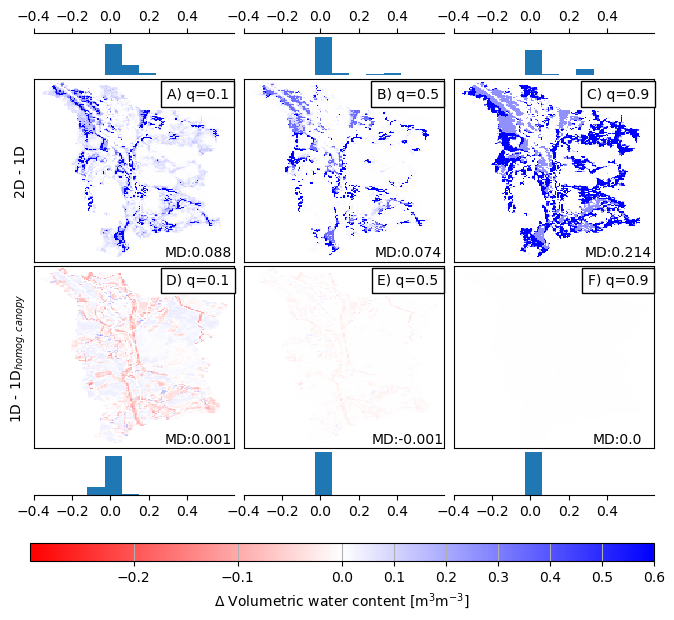

In [25]:
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl
from matplotlib.colors import TwoSlopeNorm

lims = [-0.3,0.6]
bins = 10

x, y = np.meshgrid(np.linspace(0,50,51), np.linspace(0,50,51))
z = np.linspace(-0.3,0.6,50*50).reshape(50,50)
norm = TwoSlopeNorm(vmin=z.min(), vcenter=0, vmax=z.max())
my_cmap='bwr_r'

# Choose colormap
#cmap = pl.cm.Oranges

# Get the colormap colors
#my_cmap = cmap(np.arange(cmap.N))

# Set alpha
#my_cmap[:,-1] = np.linspace(0.2, 0.9, cmap.N)
# Create new colormap
#my_cmap = ListedColormap(my_cmap)

#my_cmap = 'gist_heat_r'

#ixs = [ix1, ix2, ix3, ix4]
#axs = [ax1, ax2, ax3, ax4]

alp=0.7
ylims = [-0.3,0.6]
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(10, 3)

ax1 = fig.add_subplot(gs[1:5, 0])
ax2 = fig.add_subplot(gs[1:5, 1])
ax3 = fig.add_subplot(gs[1:5, 2])

ix1 =  fig.add_subplot(gs[0, 0])
ix2 =  fig.add_subplot(gs[0, 1])
ix3 =  fig.add_subplot(gs[0, 2])

ax4 = fig.add_subplot(gs[5:9, 0])
ax5 = fig.add_subplot(gs[5:9, 1])
ax6 = fig.add_subplot(gs[5:9, 2])

ix4 = fig.add_subplot(gs[9, 0])
ix5 = fig.add_subplot(gs[9, 1])
ix6 = fig.add_subplot(gs[9, 2])

# ax1: 2d - 1d: 0.1
im1 = (res_2d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)-res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax1, vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D', cmap=my_cmap, norm=norm)

#ix1 = inset_axes(ax1,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix1.hist((res_2d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)
          -res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)-
                                                                                                              res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix1.patch.set_alpha(0.01)

# ax4: 1d - 1d ave: 0.1
im4 = (res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)
       -res_1d_ave['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax4, cmap=my_cmap, vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D',  norm=norm)

ix4.hist((res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)
          -res_1d_ave['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)-
                                                                                                                  res_1d_ave['bucket_moisture_top'].quantile(0.1, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix4.patch.set_alpha(0.01)

# ax2: 2d - 1d: 0.5
(res_2d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
 -res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax2, cmap=my_cmap,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D', norm=norm)
#ix3 = inset_axes(ax3,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix2.hist((res_2d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
          -res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
                                                                                                 -res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix2.patch.set_alpha(0.01)

# ax5: 1d - 1d ave: 0.5
(res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
 -res_1d_ave['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax5, cmap=my_cmap,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D', norm=norm)

ix5.hist((res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
          -res_1d_ave['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)
                                                                                                     -res_1d_ave['bucket_moisture_top'].quantile(0.5, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix5.patch.set_alpha(0.01)

# ax3: 2d - 1d: 0.9
(res_2d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
 -res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax3, cmap=my_cmap,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D', norm=norm)
#ix5 = inset_axes(ax5,
#                    width="30%", # width = 30% of parent_bbox
#                    height=0.6, # height : 1 inch
#                    loc=1)
ix3.hist((res_2d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
          -res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)).values.flatten()[~np.isnan((res_2d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
                                                                                                 -res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix3.patch.set_alpha(0.01)

# ax6: 1d - 1d ave: 0.9
(res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
 -res_1d_ave['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True))[20:250,20:165].plot(
    ax=ax6, cmap=my_cmap,  vmin=ylims[0], vmax=ylims[1], add_colorbar=False, label='2D-1D', norm=norm)

ix6.hist((res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
           -res_1d_ave['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)).values.flatten()[~np.isnan((res_1d['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)
                                                                                                      -res_1d_ave['bucket_moisture_top'].quantile(0.9, dim='time', skipna=True)).values.flatten())],
         bins=bins, range=lims)
ix6.patch.set_alpha(0.01)

props = dict(facecolor='white', alpha=1)

ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')

ax5.axes.get_yaxis().set_ticklabels([])
ax5.set_ylabel('')
ax6.axes.get_yaxis().set_ticklabels([])
ax6.set_ylabel('')

ax1.text(0.82, 0.92,f'A) q=0.1', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     bbox=props)

ax1.text(0.82, 0.05,f'MD:{q1m_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes)

ax2.text(0.82, 0.92,f'B) q=0.5', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     bbox=props)

ax2.text(0.82, 0.05,f'MD:{q5m_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes)

ax3.text(0.82, 0.92,f'C) q=0.9', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes,
     bbox=props)

ax3.text(0.82, 0.05,f'MD:{q9m_2_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax3.transAxes)

ax4.text(0.82, 0.92,f'D) q=0.1', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes,
     bbox=props)

ax4.text(0.82, 0.05,f'MD:{q1m_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax4.transAxes)

ax5.text(0.82, 0.92,f'E) q=0.5', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes,
     bbox=props)

ax5.text(0.82, 0.05,f'MD:{q5m_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax5.transAxes)

ax6.text(0.82, 0.92,f'F) q=0.9', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes,
     bbox=props)

ax6.text(0.82, 0.05,f'MD:{q9m_1_1}', size=10,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax6.transAxes)

ix1.axes.get_yaxis().set_ticklabels([])
ix2.axes.get_yaxis().set_ticklabels([])
ix3.axes.get_yaxis().set_ticklabels([])

ix4.axes.get_yaxis().set_ticklabels([])
ix5.axes.get_yaxis().set_ticklabels([])
ix6.axes.get_yaxis().set_ticklabels([])

ix1.set_yticks([])
ix2.set_yticks([])
ix3.set_yticks([])

ix4.set_yticks([])
ix5.set_yticks([])
ix6.set_yticks([])

ix1.set_xticks(np.arange(-0.4,0.6,0.2))
ix2.set_xticks(np.arange(-0.4,0.6,0.2))
ix3.set_xticks(np.arange(-0.4,0.6,0.2))
ix4.set_xticks(np.arange(-0.4,0.6,0.2))
ix5.set_xticks(np.arange(-0.4,0.6,0.2))
ix6.set_xticks(np.arange(-0.4,0.6,0.2))


ix1.spines[['right', 'bottom', 'left']].set_visible(False)
ix2.spines[['right', 'bottom', 'left']].set_visible(False)
ix3.spines[['right', 'bottom', 'left']].set_visible(False)
ix4.spines[['right', 'top', 'left']].set_visible(False)
ix5.spines[['right', 'top', 'left']].set_visible(False)
ix6.spines[['right', 'top', 'left']].set_visible(False)

ix1.grid(False)
ix2.grid(False)
ix3.grid(False)
ix4.grid(False)
ix5.grid(False)
ix6.grid(False)

ix1.set_ylim(0,14000)
ix2.set_ylim(0,14000)
ix3.set_ylim(0,14000)
ix4.set_ylim(0,14000)
ix5.set_ylim(0,14000)
ix6.set_ylim(0,14000)


ix1.xaxis.set_label_position('top')
ix1.xaxis.tick_top()
ix2.xaxis.set_label_position('top')
ix2.xaxis.tick_top()
ix3.xaxis.set_label_position('top')
ix3.xaxis.tick_top()

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')

ax1.axes.get_yaxis().set_ticklabels([])
ax1.set_ylabel('')
ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_ylabel('')
ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_ylabel('')
ax4.axes.get_yaxis().set_ticklabels([])
ax4.set_ylabel('')
ax4.set_ylabel(r'1D - 1D$_{homog.canopy}$')
ax1.set_ylabel('2D - 1D')

ax1.axes.get_xaxis().set_ticklabels([])
ax1.set_xlabel('')
ax2.axes.get_xaxis().set_ticklabels([])
ax2.set_xlabel('')
ax3.axes.get_xaxis().set_ticklabels([])
ax3.set_xlabel('')

ax4.axes.get_xaxis().set_ticklabels([])
ax4.set_xlabel('')
ax5.axes.get_xaxis().set_ticklabels([])
ax5.set_xlabel('')
ax6.axes.get_xaxis().set_ticklabels([])
ax6.set_xlabel('')

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax4.set_xticks([])
ax4.set_yticks([])
ax5.set_xticks([])
ax5.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

cax = plt.axes([0.12, 0, 0.78, 0.03]) #  4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.set_label(u'Δ Volumetric water content [m$^3$m$^{-3}$]')
#plt.title('SpaFHy-2D - SpaFHy-1D', y=2)
#fig.suptitle('SpaFHy-2D - SpaFHy-1D', fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.savefig(f'spatial_models_dif_moss_{today}.png', bbox_inches='tight', dpi=300)

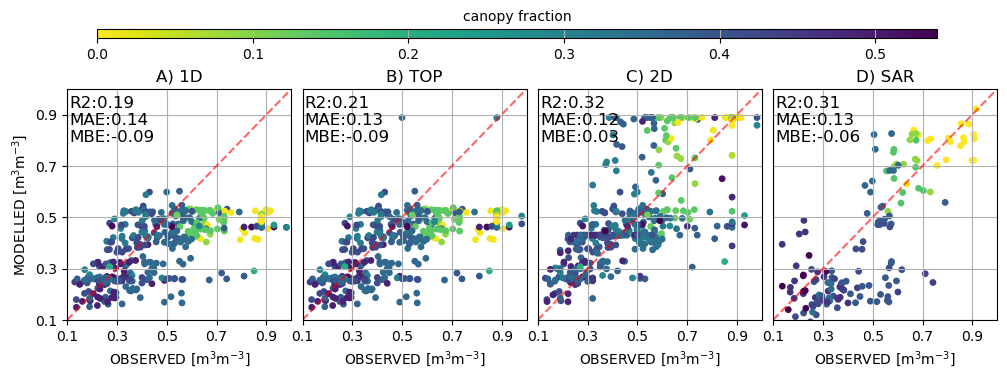

In [8]:
r2_spa_theta_1d = R2_metrics(spat_theta_pair, columns=['obs', 'mod_1d'])
r2_spa_theta_top =  R2_metrics(spat_theta_pair, columns=['obs', 'mod_top'])
r2_spa_theta_2d =  R2_metrics(spat_theta_pair, columns=['obs', 'mod_2d'])
r2_spa_theta_sar =  R2_metrics(spat_theta_pair, columns=['obs', 'sar'])

mbe_spa_theta_1d = MBE_metrics(spat_theta_pair, columns=['obs', 'mod_1d'])
mbe_spa_theta_top =  MBE_metrics(spat_theta_pair, columns=['obs', 'mod_top'])
mbe_spa_theta_2d =  MBE_metrics(spat_theta_pair, columns=['obs', 'mod_2d'])
mbe_spa_theta_sar =  MBE_metrics(spat_theta_pair, columns=['obs', 'sar'])

mae_spa_theta_1d = MAE_metrics(spat_theta_pair, columns=['obs', 'mod_1d'])
mae_spa_theta_top =  MAE_metrics(spat_theta_pair, columns=['obs', 'mod_top'])
mae_spa_theta_2d =  MAE_metrics(spat_theta_pair, columns=['obs', 'mod_2d'])
mae_spa_theta_sar =  MAE_metrics(spat_theta_pair, columns=['obs', 'sar'])

r2_spa_theta_1d_min = R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_1d'])
r2_spa_theta_top_min =  R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_top'])
r2_spa_theta_2d_min =  R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_2d'])

r2_spa_theta_1d_peat = R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_1d'])
r2_spa_theta_top_peat =  R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_top'])
r2_spa_theta_2d_peat =  R2_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_2d'])

mbe_spa_theta_1d_min = MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_1d'])
mbe_spa_theta_top_min =  MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_top'])
mbe_spa_theta_2d_min =  MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_2d'])

mbe_spa_theta_1d_peat = MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_1d'])
mbe_spa_theta_top_peat =  MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_top'])
mbe_spa_theta_2d_peat =  MBE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_2d'])

mae_spa_theta_1d_min = MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_1d'])
mae_spa_theta_top_min =  MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_top'])
mae_spa_theta_2d_min =  MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 2], columns=['obs', 'mod_2d'])

mae_spa_theta_1d_peat = MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_1d'])
mae_spa_theta_top_peat =  MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_top'])
mae_spa_theta_2d_peat =  MAE_metrics(spat_theta_pair.loc[spat_theta_pair['soiltype'] == 4], columns=['obs', 'mod_2d'])

# SCATTERPLOTS OF SPATIAL SOIL MOISTURE MEASUREMENTS AND SIMULATIONS
alp=1.0
ms=15
ylims = [0.1,1.0]
text1 = [0.01, 0.77]
text2 = [0.65, 0.01]
colorto = 'canopy_fraction'

fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

im1 = ax1.scatter(spat_theta_pair['obs'], spat_theta_pair['mod_1d'], c=spat_theta_pair[colorto], alpha=alp, s=ms, cmap='viridis_r')
#ax1.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'mod_1d'], alpha=alp, s=ms, label='treeless mire')
#ax1.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'mod_1d'], alpha=alp, s=ms, label='pine mire')
#ax1.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'mod_1d'], alpha=alp, s=ms, label='spruce mire')
#ax1.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'mod_1d'], alpha=alp, s=ms, label='mineral')
#ax1.scatter(spat_theta_pair['obs'], spat_theta_pair['mod_1d'], alpha=alp, s=ms)
ax1.plot(ylims, ylims, 'r--', alpha=0.6)
#ax1.legend(ncol=4,bbox_to_anchor=(1.48,1.2))

ax2.scatter(spat_theta_pair['obs'], spat_theta_pair['mod_top'], c=spat_theta_pair[colorto], alpha=alp, s=ms, cmap='viridis_r')
#ax2.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'mod_top'], alpha=alp, s=ms, label='open mire')
#ax2.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'mod_top'], alpha=alp, s=ms, label='pine mire')
#ax2.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'mod_top'], alpha=alp, s=ms, label='spruce mire')
#ax2.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'mod_top'], alpha=alp, s=ms, label='mineral')
ax2.plot(ylims, ylims, 'r--', alpha=0.6)

ax3.scatter(spat_theta_pair['obs'], spat_theta_pair['mod_2d'], c=spat_theta_pair[colorto], alpha=alp, s=ms, cmap='viridis_r')
#ax3.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'mod_2d'], alpha=alp, s=ms, label='open mire')
#ax3.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'mod_2d'], alpha=alp, s=ms, label='pine mire')
#ax3.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'mod_2d'], alpha=alp, s=ms, label='spruce mire')
#ax3.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'mod_2d'], alpha=alp, s=ms, label='mineral')
ax3.plot(ylims, ylims, 'r--', alpha=0.6)

ax4.scatter(spat_theta_pair['obs'], spat_theta_pair['sar'],  c=spat_theta_pair[colorto], alpha=alp, s=ms, cmap='viridis_r')
#ax4.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 4, 'sar'], alpha=alp, s=ms, label='open mire')
#ax4.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 3, 'sar'], alpha=alp, s=ms, label='pine mire')
#ax4.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 2, 'sar'], alpha=alp, s=ms, label='spruce mire')
#ax4.scatter(spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'obs'], spat_theta_pair.loc[spat_theta_pair['sitetype'] == 1, 'sar'], alpha=alp, s=ms, label='mineral')
ax4.plot(ylims, ylims, 'r--', alpha=0.6)

ax1.set_ylim(ylims)
ax1.set_xlim(ylims)
ax2.set_ylim(ylims)
ax2.set_xlim(ylims)
ax3.set_ylim(ylims)
ax3.set_xlim(ylims)
ax4.set_ylim(ylims)
ax4.set_xlim(ylims)

ax1.set_xlabel('OBSERVED [m$^3$m$^{-3}$]')
ax1.set_ylabel('MODELLED [m$^3$m$^{-3}$]')
ax2.set_xlabel('OBSERVED [m$^3$m$^{-3}$]')
ax3.set_xlabel('OBSERVED [m$^3$m$^{-3}$]')
ax4.set_xlabel('OBSERVED [m$^3$m$^{-3}$]')


ax1.set_title('A) 1D')
ax2.set_title('B) TOP')
ax3.set_title('C) 2D')
ax4.set_title('D) SAR')

ax1.text(text1[0], text1[1], f'R2:{r2_spa_theta_1d}\nMAE:{mae_spa_theta_1d}\nMBE:{mbe_spa_theta_1d}',
         fontsize=12, color='black', transform=ax1.transAxes)
ax2.text(text1[0], text1[1], f'R2:{r2_spa_theta_top}\nMAE:{mae_spa_theta_top}\nMBE:{mbe_spa_theta_top}',
         fontsize=12, color='black', transform=ax2.transAxes)
ax3.text(text1[0], text1[1], f'R2:{r2_spa_theta_2d}\nMAE:{mae_spa_theta_2d}\nMBE:{mbe_spa_theta_2d}',
         fontsize=12, color='black', transform=ax3.transAxes)
ax4.text(text1[0], text1[1], f'R2:{r2_spa_theta_sar}\nMAE:{mae_spa_theta_sar}\nMBE:{mbe_spa_theta_sar}',
         fontsize=12, color='black', transform=ax4.transAxes)

#ax1.text(text2[0], text2[1], f'R2:{r2_spa_theta_1d_min}\nMAE:{mae_spa_theta_1d_min}\nMBE:{mbe_spa_theta_1d_min}',
#         fontsize=12, color='brown', transform=ax1.transAxes)
#ax2.text(text2[0], text2[1], f'R2:{r2_spa_theta_top_min}\nMAE:{mae_spa_theta_top_min}\nMBE:{mbe_spa_theta_top_min}',
#         fontsize=12, color='brown', transform=ax2.transAxes)
#ax3.text(text2[0], text2[1], f'R2:{r2_spa_theta_2d_min}\nMAE:{mae_spa_theta_2d_min}\nMBE:{mbe_spa_theta_2d_min}',
#         fontsize=12, color='brown', transform=ax3.transAxes)

ax2.axes.get_yaxis().set_ticklabels([])
ax2.set_yticks([])
ax2.yaxis.set_ticks_position('none')

cax = plt.axes([0.15, 1.05, 0.70, 0.03]) #  4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
cbar1.ax.set_title('canopy fraction',fontsize=10)

ax3.axes.get_yaxis().set_ticklabels([])
ax3.set_yticks([])
ax3.yaxis.set_ticks_position('none')

ax4.axes.get_yaxis().set_ticklabels([])
ax4.set_yticks([])
ax4.yaxis.set_ticks_position('none')

ax1.set_xticks(np.arange(ylims[0], ylims[1], 0.2))
ax1.set_yticks(np.arange(ylims[0], ylims[1], 0.2))
ax2.set_xticks(np.arange(ylims[0], ylims[1], 0.2))
ax2.set_yticks(np.arange(ylims[0], ylims[1], 0.2))
ax3.set_xticks(np.arange(ylims[0], ylims[1], 0.2))
ax3.set_yticks(np.arange(ylims[0], ylims[1], 0.2))
ax4.set_xticks(np.arange(ylims[0], ylims[1], 0.2))
ax4.set_yticks(np.arange(ylims[0], ylims[1], 0.2))

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig(f'spatial_theta_scat_sar_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'spatial_theta_scat_sar_{today}.png', bbox_inches='tight', dpi=300)

In [11]:
# HISTOGRAMS

june_id = np.where(pd.to_datetime(dates_spa).month == 6)[0]
june_id_sar = np.where(pd.to_datetime(dates_sar_m).month == 6)[0]
june_id_sarmask = np.where((dates_spa.isin(dates_sar_m)) & (dates_spa.month == 6))[0]

july_id = np.where(pd.to_datetime(dates_spa).month == 7)[0]
july_id_sar = np.where(pd.to_datetime(dates_sar_m).month == 7)[0]
july_id_sarmask = np.where((dates_spa.isin(dates_sar_m)) & (dates_spa.month == 7))[0]

august_id = np.where(pd.to_datetime(dates_spa).month == 8)[0]
august_id_sar = np.where(pd.to_datetime(dates_sar_m).month == 8)[0]
august_id_sarmask = np.where((dates_spa.isin(dates_sar_m)) & (dates_spa.month == 8))[0]

sept_id = np.where(pd.to_datetime(dates_spa).month == 9)[0]
sept_id_sar = np.where(pd.to_datetime(dates_sar_m).month == 9)[0]
sept_id_sarmask = np.where((dates_spa.isin(dates_sar_m)) & (dates_spa.month == 9))[0]


top_moist_peat = np.array(res_top['bucket_moisture_root']).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d2_moist_peat = np.array(res_2d['bucket_moisture_root']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d2_top_moist_peat = np.array(res_2d['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d2_top_ave_moist_peat = np.array(res_2d_ave['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d2_top_ndr_moist_peat = np.array(res_2d_ndr['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]

d1_moist_peat = np.array(res_1d['bucket_moisture_root']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d1_top_moist_peat = np.array(res_1d['bucket_moisture_top']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,peat_id]

sar_moist_peat = np.array(sar_m['theta']).reshape(sar_m['theta'].shape[0], -1)[:,peat_id]
d2_sarmask_moist_peat = np.array(res_2d['bucket_moisture_root']*sar_mask).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
d1_sarmask_moist_peat = np.array(res_1d['bucket_moisture_root']*sar_mask).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,peat_id]
top_sarmask_moist_peat = np.array(res_top['bucket_moisture_root']*sar_mask).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,peat_id]


top_moist_mineral = np.array(res_top['bucket_moisture_root']).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d2_moist_mineral = np.array(res_2d['bucket_moisture_root']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d2_top_moist_mineral = np.array(res_2d['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d2_top_ave_moist_mineral = np.array(res_2d_ave['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d2_top_ndr_moist_mineral = np.array(res_2d_ndr['bucket_moisture_top']).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]

d1_moist_mineral = np.array(res_1d['bucket_moisture_root']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d1_top_moist_mineral = np.array(res_1d['bucket_moisture_top']).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]

sar_moist_mineral = np.array(sar_m['theta']).reshape(sar_m['theta'].shape[0], -1)[:,mineral_id]
d2_sarmask_moist_mineral = np.array(res_2d['bucket_moisture_root']*sar_mask).reshape(res_2d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
d1_sarmask_moist_mineral = np.array(res_1d['bucket_moisture_root']*sar_mask).reshape(res_1d['bucket_moisture_root'].shape[0], -1)[:,mineral_id]
top_sarmask_moist_mineral = np.array(res_top['bucket_moisture_root']*sar_mask).reshape(res_top['bucket_moisture_root'].shape[0], -1)[:,mineral_id]

alp=0.6
peat_lims = [0.1,0.9]
min_lims = [0.1,0.9]

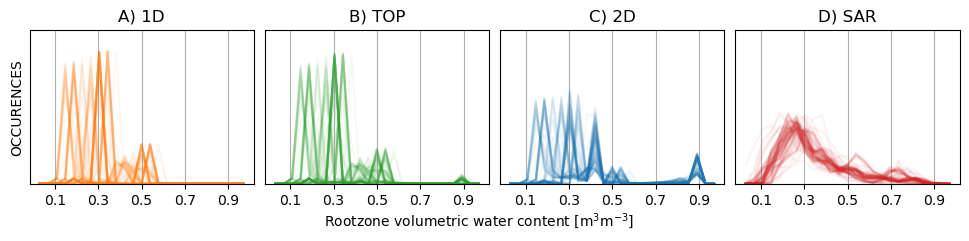

In [35]:
# HISTOGRAM PLOT
text1 = [0.6, 0.90]
alp=0.05
peat_lims = [0.01,0.99]
min_lims = [0.01,0.99]
ylims=[0,12000]
ylims1b=[0,6000]

fig = plt.figure(figsize=(12,2))
gs = fig.add_gridspec(1, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


for i in dates_sar_e:
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax1.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax2.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax3.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_e['theta'].sel(time=i)).flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax4.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges
    
for i in dates_sar_m:
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax1.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax2.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()*sar_mask.flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax3.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_m['theta'].sel(time=i)).flatten(), bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax4.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges

ax1.axes.get_yaxis().set_ticklabels([])
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax4.set_yticks([])


ax2.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax4.axes.get_yaxis().set_ticklabels([])

ax2.yaxis.set_ticks_position('none')
ax3.yaxis.set_ticks_position('none')
ax4.yaxis.set_ticks_position('none')
ax6.yaxis.set_ticks_position('none')
ax7.yaxis.set_ticks_position('none')
ax8.yaxis.set_ticks_position('none')

ax1.set_xticks(np.arange(0.1,1.0,0.2))
ax2.set_xticks(np.arange(0.1,1.0,0.2))
ax3.set_xticks(np.arange(0.1,1.0,0.2))
ax4.set_xticks(np.arange(0.1,1.0,0.2))

ax1.set_title('A) 1D')
ax2.set_title('B) TOP')
ax3.set_title('C) 2D')
ax4.set_title('D) SAR')

ax1.set_ylim(ylims)
ax2.set_ylim(ylims)
ax3.set_ylim(ylims)
ax4.set_ylim(ylims1b)

ax1.set_ylabel('OCCURENCES')

plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.text(0.5, -0.1, 'Rootzone volumetric water content [m$^3$m$^{-3}$]', ha='center')

plt.savefig(f'histogram_{today}.png', bbox_inches='tight', dpi=300)

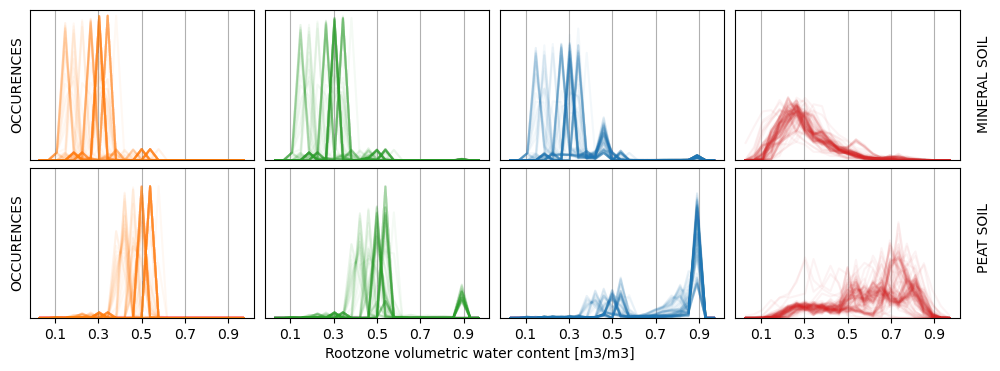

In [82]:
# HISTOGRAM PLOT
text1 = [0.6, 0.90]
alp=0.05
peat_lims = [0.01,0.99]
min_lims = [0.01,0.99]
ylims=[0,12000]
ylims1b=[0,6000]
ylims2=[0,800]
ylims2b=[0,400]

fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])

for i in dates_sar_e:
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax1.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax2.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax3.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_e['theta'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax4.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax5.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax6.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax7.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_e['theta'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax8.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges
    
for i in dates_sar_m:
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax1.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax2.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges

    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax3.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_m['theta'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 1).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax4.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_1d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax5.plot(bin_centers,n, color='tab:orange', alpha=alp, label='1D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_top['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax6.plot(bin_centers,n, color='tab:green', alpha=alp, label='TOP') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(res_2d['bucket_moisture_root'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax7.plot(bin_centers,n, color='tab:blue', alpha=alp, label='2D') ## using bin_centers rather than edges
    
    n,x, = np.histogram(np.array(sar_m['theta'].sel(time=i)).flatten()[np.array(res_2d['parameters_sitetype'] == 4).flatten()], bins=25, range=min_lims)
    bin_centers = 0.5*(x[1:]+x[:-1])
    ax8.plot(bin_centers,n, color='tab:red', alpha=alp, label='SAR') ## using bin_centers rather than edges
    
ax1.axes.get_yaxis().set_ticklabels([])
ax1.set_yticks([])
ax2.set_yticks([])

ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax7.set_yticks([])
ax8.set_yticks([])

ax2.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticklabels([])
ax4.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticklabels([])
ax2.axes.get_xaxis().set_ticklabels([])
ax3.axes.get_xaxis().set_ticklabels([])
ax4.axes.get_xaxis().set_ticklabels([])

ax5.axes.get_yaxis().set_ticklabels([])
ax6.axes.get_yaxis().set_ticklabels([])
ax7.axes.get_yaxis().set_ticklabels([])
ax8.axes.get_yaxis().set_ticklabels([])

ax1.xaxis.set_ticks_position('none')
ax2.xaxis.set_ticks_position('none')
ax3.xaxis.set_ticks_position('none')
ax4.xaxis.set_ticks_position('none')

ax2.yaxis.set_ticks_position('none')
ax3.yaxis.set_ticks_position('none')
ax4.yaxis.set_ticks_position('none')
ax6.yaxis.set_ticks_position('none')
ax7.yaxis.set_ticks_position('none')
ax8.yaxis.set_ticks_position('none')

ax1.set_xticks(np.arange(0.1,1.0,0.2))
ax2.set_xticks(np.arange(0.1,1.0,0.2))
ax3.set_xticks(np.arange(0.1,1.0,0.2))
ax4.set_xticks(np.arange(0.1,1.0,0.2))
ax5.set_xticks(np.arange(0.1,1.0,0.2))
ax6.set_xticks(np.arange(0.1,1.0,0.2))
ax7.set_xticks(np.arange(0.1,1.0,0.2))
ax8.set_xticks(np.arange(0.1,1.0,0.2))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.text(0.5, 0.01, 'Rootzone volumetric water content [m3/m3]', ha='center')

ax1.set_ylim(ylims)
ax2.set_ylim(ylims)
ax3.set_ylim(ylims)
ax4.set_ylim(ylims1b)
ax5.set_ylim(ylims2)
ax6.set_ylim(ylims2)
ax7.set_ylim(ylims2)
ax8.set_ylim(ylims2b)

ax1.set_ylabel('OCCURENCES')
ax5.set_ylabel('OCCURENCES')

fig.text(0.92, 0.58, 'MINERAL SOIL', rotation='vertical', ha='center')
fig.text(0.92, 0.23, 'PEAT SOIL', rotation='vertical', ha='center')

plt.savefig(f'histogram_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'histogram_{today}.png', bbox_inches='tight', dpi=300)

In [36]:
#nans = [np.nan] * len(pd.date_range(i14_all.index[0], i14_all.index[-1], freq='D'))
#dates = pd.date_range(i14_all.index[0], i14_all.index[-1], freq='D')
#missing = pd.Series(index=dates, data=nans)

start_day = pd.to_datetime('2019-06-01')
end_day = pd.to_datetime('2019-09-11')
i14_df = pd.DataFrame()
i14_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i14_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i14_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i14_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i14_all = pd.concat([i14_df['0'], i14_df['10'], i14_df['20'], i14_df['30'], missing]).sort_index()

i18_df = pd.DataFrame()
i18_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i18_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i18_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i18_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i18_all = pd.concat([i18_df['0'], i18_df['10'], i18_df['20'], i18_df['30'], missing]).sort_index()

i7_df = pd.DataFrame()
i7_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i7') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i7_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i7') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i7_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i7') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i7_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i7') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i17_all = pd.concat([i7_df['0'], i7_df['10'], i7_df['20'], i7_df['30'], missing]).sort_index()

i8_df = pd.DataFrame()
i8_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i8') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i8_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i8') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i8_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i8') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i8_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i8') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i8_all = pd.concat([i8_df['0'], i8_df['10'], i8_df['20'], i8_df['30'], missing]).sort_index()

i17_df = pd.DataFrame()
i17_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i17') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i17_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i17') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i17_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i17') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i17_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i17') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i17_all = pd.concat([i17_df['0'], i17_df['10'], i17_df['20'], i17_df['30'], missing]).sort_index()

i16_df = pd.DataFrame()
i16_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i16_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i16_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i16_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i16_all = pd.concat([i16_df['0'], i16_df['10'], i16_df['20'], i16_df['30'], missing]).sort_index()

i20_df = pd.DataFrame()
i20_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i20_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i20_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i20_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i20_all = pd.concat([i20_df['0'], i20_df['10'], i20_df['20'], i20_df['30'], missing]).sort_index()

i21_df = pd.DataFrame()
i21_df['0'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i21_df['10'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
                   (theta_spat_gpd['z'] == 10) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i21_df['20'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
i21_df['30'] = theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
                   (theta_spat_gpd.index <= end_day), 'theta']
#i21_all = pd.concat([i21_df['0'], i21_df['10'], i21_df['20'], i21_df['30'], missing]).sort_index()

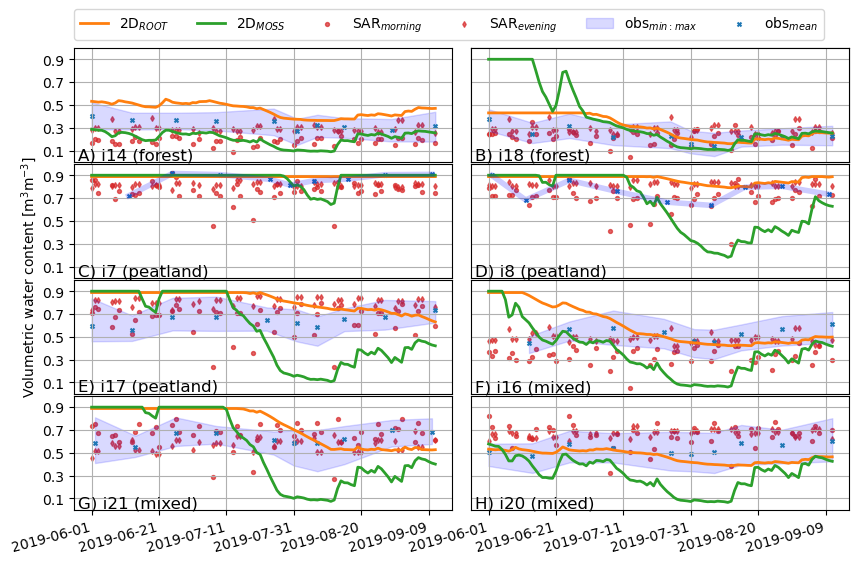

In [37]:
# temporal sar model obs

# SAR SPATIAL PLOTS
start_day = pd.to_datetime('2019-06-01')
end_day = pd.to_datetime('2019-09-11')
window = pd.date_range(start_day, end_day, freq='D')

window_sar = window[window.isin(dates_sar_m)]
window_sar2 = window[window.isin(dates_sar_e)]

start = np.where(pd.to_datetime(dates_spa) == start_day)[0][0]
end = np.where(pd.to_datetime(dates_spa) == end_day)[0][0]

alp=0.5
meas_depth=10
lwidth = 2
text1 = [0.01, 0.02]
obsalp = 0.15
ylims = [0.2,0.88]
ylimstemp = [0.08,0.4]
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(12, 2)

ax0 = fig.add_subplot(gs[0:3, 1])
ax1 = fig.add_subplot(gs[0:3, 0])
ax2 = fig.add_subplot(gs[0:3, 1])
ax3 = fig.add_subplot(gs[3:6, 0])
ax4 = fig.add_subplot(gs[3:6, 1])
ax5 = fig.add_subplot(gs[6:9, 0])
ax6 = fig.add_subplot(gs[6:9, 1])
ax7 = fig.add_subplot(gs[9:12, 0])
ax8 = fig.add_subplot(gs[9:12, 1])



# ax1
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax1, linewidth=lwidth, linestyle='-',  color='tab:orange', label='2D$_{ROOT}$')

#ax1.plot(res_2d['bucket_moisture_root'].sel(
#    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
#    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0],
#    time=window, method='nearest'), linewidth=lwidth, color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax1, linewidth=lwidth, linestyle='-',  color='tab:green', label='2D$_{MOSS}$')

#ax1.plot(res_2d['bucket_moisture_top'].sel(
#    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
#    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0],
#    time=window, method='nearest'), linewidth=lwidth, color='tab:green')

ax1.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8, label='SAR$_{morning}$')

ax1.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i14', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8, label='SAR$_{evening}$')


#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
#                   (theta_spat_gpd['z'] == meas_depth) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax1, alpha=0.7, marker='o', markersize=5,   color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
#                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax1, alpha=0.7, marker='o', markersize=5,   color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i14') &
#                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax1, alpha=0.7, marker='o', markersize=5,   color='tab:blue')
ax1.fill_between(i14_df.index, i14_df.min(axis=1), i14_df.max(axis=1), color='blue', alpha=obsalp,  label='obs$_{min:max}$')
ax1.scatter(i14_df.index,i14_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1,  label='obs$_{mean}$')
ax1.legend(ncol=6,bbox_to_anchor=(2,1.4))

#ax1.violinplot(i14_df.index, i14_df)

#seaborn.boxplot(x=i14_all.index, y=i14_all, ax=ax1, color='tab:blue')

ax1.text(text1[0], text1[1], 'A) i14 (forest)',
         fontsize=12, transform=ax1.transAxes)


# ax2
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax2, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax2, linewidth=lwidth, linestyle='-',  color='tab:green')

ax2.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax2.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i18', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
#                   (theta_spat_gpd['z'] == meas_depth) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax2, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
#                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax2,  alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i18') &
#                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax2,  alpha=0.7, marker='o', markersize=5,  color='tab:blue')
ax2.fill_between(i18_df.index, i18_df.min(axis=1), i18_df.max(axis=1), color='blue', alpha=obsalp)
#ax2.violinplot(theta_spat_gpd.index, i18_df.min(axis=1), i18_df.max(axis=1), color='blue', alpha=obsalp)
ax2.scatter(i18_df.index,i18_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax2.text(text1[0], text1[1], 'B) i18 (forest)',
         fontsize=12, transform=ax2.transAxes)

# ax3
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax3, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax3, linewidth=lwidth, linestyle='-',  color='tab:green')

ax3.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax3.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i7', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)


#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i7') &
#                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax3, alpha=0.7, marker='o', markersize=5,  color='tab:blue')
#ax3.fill_between(i7_df.index, i7_df.min(axis=1), i7_df.max(axis=1), linewidth=3, color='blue', alpha=0.4)
ax3.plot(i7_df.index, i7_df.max(axis=1), linewidth=4, color='blue', alpha=0.2)
ax3.scatter(i7_df.index,i7_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax3.text(text1[0], text1[1], 'C) i7 (peatland)',
         fontsize=12, transform=ax3.transAxes)

# ax4
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax4, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax4, linewidth=lwidth, linestyle='-',  color='tab:green')

ax4.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax4.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i8', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i8') &
#                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax4, alpha=0.7, marker='o', markersize=5,  color='tab:blue')
#ax4.fill_between(i8_df.index, i8_df.min(axis=1), i8_df.max(axis=1), linewidth=3, color='blue', alpha=0.4)
ax4.plot(i8_df.index, i8_df.max(axis=1), linewidth=4, color='blue', alpha=0.2)
ax4.scatter(i8_df.index,i8_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax4.text(text1[0], text1[1], 'D) i8 (peatland)',
         fontsize=12, transform=ax4.transAxes)

# ax5
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax5, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax5, linewidth=lwidth, linestyle='-',  color='tab:green')

ax5.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax5.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i17', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i17') &
#                   (theta_spat_gpd['z'] == 0) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax5, alpha=0.7, marker='o', markersize=5, color='tab:blue')
ax5.fill_between(i17_df.index, i17_df.min(axis=1), i17_df.max(axis=1), color='blue', alpha=obsalp)
ax5.scatter(i17_df.index,i17_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax5.text(text1[0], text1[1], 'E) i17 (peatland)',
         fontsize=12, transform=ax5.transAxes)

# ax6
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax6, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax6, linewidth=lwidth, linestyle='-',  color='tab:green')

ax6.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax6.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i16', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
#                   (theta_spat_gpd['z'] == meas_depth) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax6, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
#                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax6, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i16') &
#                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax6, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

ax6.fill_between(i16_df.index, i16_df.min(axis=1), i16_df.max(axis=1), color='blue', alpha=obsalp)
ax6.scatter(i16_df.index,i16_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax6.text(text1[0], text1[1], 'F) i16 (mixed)',
         fontsize=12, transform=ax6.transAxes)


# ax7
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax7, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax7, linewidth=lwidth, linestyle='-',  color='tab:green')

ax7.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax7.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i21', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
#                   (theta_spat_gpd['z'] == meas_depth) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax7, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
#                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax7, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i21') &
#                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax7, alpha=0.7, marker='o', markersize=5,  color='tab:blue')

ax7.fill_between(i21_df.index, i21_df.min(axis=1), i21_df.max(axis=1), color='blue', alpha=obsalp)
ax7.scatter(i21_df.index,i21_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)

ax7.text(text1[0], text1[1], 'G) i21 (mixed)',
         fontsize=12, transform=ax7.transAxes)

# ax8
res_2d['bucket_moisture_root'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax8, linewidth=lwidth, linestyle='-',  color='tab:orange')

res_2d['bucket_moisture_top'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].x[0],
    time=window, method='nearest').plot(ax=ax8, linewidth=lwidth, linestyle='-',  color='tab:green')

ax8.scatter(window_sar, sar_m['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', alpha=0.7, s=8)

ax8.scatter(window_sar, sar_e['theta'].sel(
    lat=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].y[0],
    lon=theta_spat_gpd.loc[theta_spat_gpd['ID_i'] == 'i20', 'geometry'].x[0], time=window_sar, method='nearest'),
    color='tab:red', marker='d', alpha=0.7, s=8)

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
#                   (theta_spat_gpd['z'] == meas_depth) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax8, alpha=0.7, color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
#                   (theta_spat_gpd['z'] == 20) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax8, alpha=0.7, color='tab:blue')

#theta_spat_gpd.loc[(theta_spat_gpd['ID_i'] == 'i20') &
#                   (theta_spat_gpd['z'] == 30) & (theta_spat_gpd.index >= start_day) &
#                   (theta_spat_gpd.index <= end_day), 'theta'].plot(ax=ax8, alpha=0.7, color='tab:blue')

ax8.fill_between(i20_df.index, i20_df.min(axis=1), i20_df.max(axis=1), color='blue', alpha=obsalp)
ax8.scatter(i20_df.index,i20_df.mean(axis=1), color='tab:blue', s=8, marker='x',  alpha=1)


ax8.text(text1[0], text1[1], 'H) i20 (mixed)',
         fontsize=12, transform=ax8.transAxes)

#ax0.xaxis.set_ticks_position('none')

ax0.axes.xaxis.set_ticklabels([])
ax0.xaxis.set_ticks_position('none')

ax1.axes.xaxis.set_ticklabels([])
ax1.xaxis.set_ticks_position('none')

ax2.axes.xaxis.set_ticklabels([])
ax2.xaxis.set_ticks_position('none')

ax3.axes.xaxis.set_ticklabels([])
ax3.xaxis.set_ticks_position('none')

ax4.axes.xaxis.set_ticklabels([])
ax4.xaxis.set_ticks_position('none')

ax5.axes.xaxis.set_ticklabels([])
ax5.xaxis.set_ticks_position('none')

ax6.axes.xaxis.set_ticklabels([])
ax6.xaxis.set_ticks_position('none')

ax0.axes.yaxis.set_ticklabels([])
ax0.yaxis.set_ticks_position('none')

ax2.axes.yaxis.set_ticklabels([])
ax2.yaxis.set_ticks_position('none')

ax4.axes.yaxis.set_ticklabels([])
ax4.yaxis.set_ticks_position('none')

ax6.axes.yaxis.set_ticklabels([])
ax6.yaxis.set_ticks_position('none')

ax8.axes.yaxis.set_ticklabels([])
ax8.yaxis.set_ticks_position('none')

ax1.set_ylabel('')
ax2.set_ylabel('')
ax4.set_ylabel('')
ax6.set_ylabel('')
ax8.set_ylabel('')

ax1.set_ylim([0.0,1.0])
ax2.set_ylim([0.0,1.0])
ax3.set_ylim([0.0,1.0])
ax4.set_ylim([0.0,1.0])
ax5.set_ylim([0.0,1.0])
ax6.set_ylim([0.0,1.0])
ax7.set_ylim([0.0,1.0])
ax8.set_ylim([0.0,1.0])

ax1.set_yticks(np.arange(0.1,1,0.2))
ax2.set_yticks(np.arange(0.1,1,0.2))
ax3.set_yticks(np.arange(0.1,1,0.2))
ax4.set_yticks(np.arange(0.1,1,0.2))
ax5.set_yticks(np.arange(0.1,1,0.2))
ax6.set_yticks(np.arange(0.1,1,0.2))
ax7.set_yticks(np.arange(0.1,1,0.2))
ax8.set_yticks(np.arange(0.1,1,0.2))


ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')
ax7.set_title('')
ax8.set_title('')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax6.set_xlabel('')
ax7.set_xlabel('')
ax8.set_xlabel('')

#ax1.set_xticks(pd.date_range(i14_all.index[0], i14_all.index[-1], freq='20D'))
ax1.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax2.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax3.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax4.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax5.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax6.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax7.set_xticks(pd.date_range(start_day, end_day, freq='20D'))
ax8.set_xticks(pd.date_range(start_day, end_day, freq='20D'))

ax7.xaxis.set_tick_params(rotation=15)
ax8.xaxis.set_tick_params(rotation=15)

ax1.set_ylabel(r'')
ax3.set_ylabel(r'')
ax5.set_ylabel(r'')
ax7.set_ylabel(r'')

fig.text(0.07, 0.5, 'Volumetric water content [m$^3$m$^{-3}]$', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.05, hspace=0.05)

#plt.savefig(f'sar_spa_temp_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'sar_spa_temp_{today}.png', bbox_inches='tight', dpi=300)

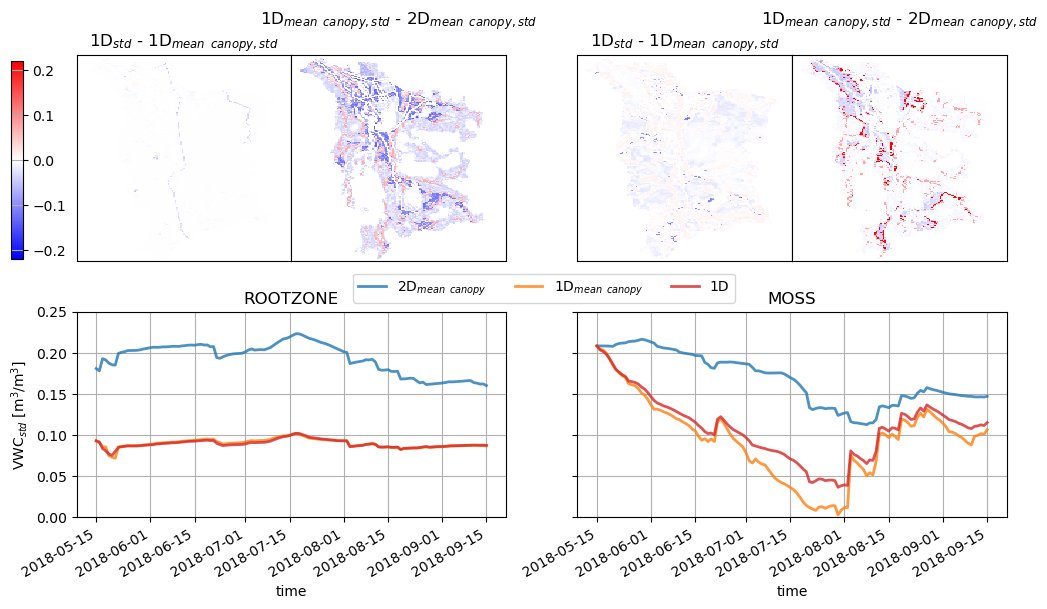

In [4]:
period = pd.date_range('2018-05-15', '2018-09-15', freq='D')
day = '2018-07-15'
vlims = [-0.22, 0.22]
cmap = 'bwr'
lw = 2

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 13)

ax0 = fig.add_subplot(gs[0, 0:3])
ax1 = fig.add_subplot(gs[0, 3:6])
ax2 = fig.add_subplot(gs[0, 7:10])
ax3 = fig.add_subplot(gs[0, 10:13])

ax4 = fig.add_subplot(gs[1, 0:6])
ax5 = fig.add_subplot(gs[1, 7:])

im1 = (res_1d['bucket_moisture_root'].sel(time=period).std(dim=['time']) - res_1d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']))[zy,zx].plot(ax=ax0, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
(res_1d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']) - (res_2d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']))*dmask)[zy,zx].plot(ax=ax1, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
im3 = (res_1d['bucket_moisture_top'].sel(time=period).std(dim=['time']) - res_1d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']))[zy,zx].plot(ax=ax2, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
(res_1d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']) - (res_2d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']))*dmask)[zy,zx].plot(ax=ax3, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)

(res_2d_ave['bucket_moisture_root'].sel(time=period)*dmask).std(dim=['lat','lon']).plot(ax=ax4, alpha=0.8, linewidth=lw, color='tab:blue', label='2D$_{mean}$ $_{canopy}$')
#res_2d_ndr['bucket_moisture_root'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax4, alpha=0.8, color='tab:green', )
#res_2d['bucket_moisture_root'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax4, color='tab:green', alpha=0.8, label='2D')
res_1d_ave['bucket_moisture_root'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax4, alpha=0.8, linewidth=lw,  color='tab:orange', label='1D$_{mean}$ $_{canopy}$')
res_1d['bucket_moisture_root'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax4, alpha=0.8, linewidth=lw,  color='tab:red', label='1D')
#res_1d_ndr['bucket_moisture_root'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax4, color='black', linewidth=lw, alpha=0.8)
ax4.legend(ncol=5, bbox_to_anchor=(1.55,1.22))

(res_2d_ave['bucket_moisture_top'].sel(time=period)*dmask).std(dim=['lat','lon']).plot(ax=ax5, alpha=0.8, linewidth=lw,  color='tab:blue')
#res_2d['bucket_moisture_top'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax5, color='tab:green', alpha=0.8)
res_1d_ave['bucket_moisture_top'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax5, alpha=0.8, linewidth=lw,  color='tab:orange')
res_1d['bucket_moisture_top'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax5, alpha=0.8, linewidth=lw,  color='tab:red')
#res_1d_ndr['bucket_moisture_top'].sel(time=period).std(dim=['lat','lon']).plot(ax=ax5, color='black', alpha=0.8)

ax0.axes.get_xaxis().set_ticklabels([])
ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticklabels([])
ax0.axes.get_yaxis().set_ticks([])

ax1.axes.get_xaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_yaxis().set_ticks([])

ax2.axes.get_xaxis().set_ticklabels([])
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticklabels([])
ax2.axes.get_yaxis().set_ticks([])

ax3.axes.get_xaxis().set_ticklabels([])
ax3.axes.get_xaxis().set_ticks([])
ax3.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticks([])

ax5.axes.get_yaxis().set_ticklabels([])

ax0.set_title('1D$_{std}$ - 1D$_{mean}$ $_{canopy,std}$')
ax1.set_title('1D$_{mean}$ $_{canopy,std}$ - 2D$_{mean}$ $_{canopy,std}$\n')

ax2.set_title('1D$_{std}$ - 1D$_{mean}$ $_{canopy,std}$')
ax3.set_title('1D$_{mean}$ $_{canopy,std}$ - 2D$_{mean}$ $_{canopy,std}$\n')

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4.set_ylim([0, 0.25])
ax5.set_ylim([0, 0.25])

#cax = plt.axes([0.12, 0.53, 0.3, 0.02]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
#cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
#cbar1.set_label('VWC [m$^3$/m$^3$]')

#cax2 = plt.axes([0.62, 0.53, 0.3, 0.02]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
#cbar2 = plt.colorbar(im3, cax=cax2, orientation='horizontal')
#cbar2.set_label('VWC [m$^3$/m$^3$]')

#cax3 = plt.axes([0.49, 0.54, 0.01, 0.33]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
cax3 = plt.axes([0.07, 0.54, 0.01, 0.33]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53

cbar3 = plt.colorbar(im3, cax=cax3, orientation='vertical')
#cbar3.set_label('VWC [m$^3$/m$^3$]')

#ax0.set_ylabel('Std VWC [m$^3$/m$^3$]')
ax4.set_ylabel('VWC$_{std}$ [m$^3$/m$^3$]')
ax1.set_ylabel('')
ax3.set_ylabel('')

ax5.set_ylabel('')

ax4.set_title('ROOTZONE')
ax5.set_title('MOSS')

plt.subplots_adjust(wspace=0.0, hspace=0.25)

#plt.savefig(f'moisture_drivers_{today}.pdf', bbox_inches='tight', dpi=300)
#plt.savefig(f'moisture_drivers_{today}.png', bbox_inches='tight', dpi=300)

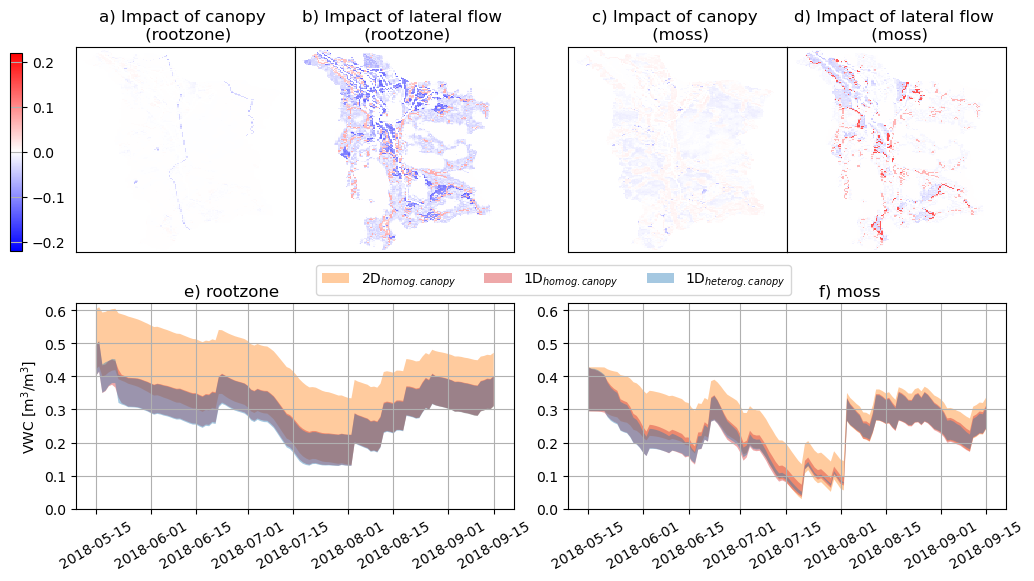

In [11]:
period = pd.date_range('2018-05-15', '2018-09-15', freq='D')
day = '2018-07-15'
vlims = [-0.22, 0.22]
cmap = 'bwr'
lw = 1.5

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(2, 17)

ax0 = fig.add_subplot(gs[0, 0:4])
ax1 = fig.add_subplot(gs[0, 4:8])
ax2 = fig.add_subplot(gs[0, 9:13])
ax3 = fig.add_subplot(gs[0, 13:17])

ax4 = fig.add_subplot(gs[1, 0:8])
ax5 = fig.add_subplot(gs[1, 9:])

im1 = (res_1d['bucket_moisture_root'].sel(time=period).std(dim=['time']) - res_1d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']))[zy,zx].plot(ax=ax0, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
(res_1d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']) - (res_2d_ave['bucket_moisture_root'].sel(time=period).std(dim=['time']))*dmask)[zy,zx].plot(ax=ax1, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
im3 = (res_1d['bucket_moisture_top'].sel(time=period).std(dim=['time']) - res_1d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']))[zy,zx].plot(ax=ax2, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)
(res_1d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']) - (res_2d_ave['bucket_moisture_top'].sel(time=period).std(dim=['time']))*dmask)[zy,zx].plot(ax=ax3, vmin=vlims[0], vmax=vlims[1], cmap=cmap, add_colorbar=False)

ax4.fill_between(period, 
                 (res_2d_ave['bucket_moisture_root'].sel(time=period)*dmask).mean(dim=['lat','lon'])-((res_2d_ave['bucket_moisture_root'].sel(time=period)*dmask).std(dim=['lat','lon'])/2),
                 (res_2d_ave['bucket_moisture_root'].sel(time=period)*dmask).mean(dim=['lat','lon'])+((res_2d_ave['bucket_moisture_root'].sel(time=period)*dmask).std(dim=['lat','lon'])/2),
                 alpha=0.4,facecolor='tab:orange', linewidth=0, label='2D$_{homog.canopy}$'
                )
ax4.fill_between(period, 
                 (res_1d['bucket_moisture_root'].sel(time=period).mean(dim=['lat','lon']))-((res_1d['bucket_moisture_root'].sel(time=period)).std(dim=['lat','lon'])/2),
                 (res_1d['bucket_moisture_root'].sel(time=period).mean(dim=['lat','lon']))+((res_1d['bucket_moisture_root'].sel(time=period)).std(dim=['lat','lon'])/2),
                 alpha=0.4, facecolor='tab:red', linewidth=0, label='1D$_{homog.canopy}$'
                )
ax4.fill_between(period, 
                 (res_1d_ave['bucket_moisture_root'].sel(time=period).mean(dim=['lat','lon']))-((res_1d_ave['bucket_moisture_root'].sel(time=period)).std(dim=['lat','lon'])/2),
                 (res_1d_ave['bucket_moisture_root'].sel(time=period).mean(dim=['lat','lon']))+((res_1d_ave['bucket_moisture_root'].sel(time=period)).std(dim=['lat','lon'])/2),
                 alpha=0.4, facecolor='tab:blue', linewidth=0,  label='1D$_{heterog.canopy}$'
                )
ax4.legend(ncol=5, bbox_to_anchor=(1.65,1.22))

ax5.fill_between(period, 
                 (res_2d_ave['bucket_moisture_top'].sel(time=period)*dmask).mean(dim=['lat','lon'])-((res_2d_ave['bucket_moisture_top'].sel(time=period)*dmask).std(dim=['lat','lon'])/2),
                 (res_2d_ave['bucket_moisture_top'].sel(time=period)*dmask).mean(dim=['lat','lon'])+((res_2d_ave['bucket_moisture_top'].sel(time=period)*dmask).std(dim=['lat','lon'])/2),
                 alpha=0.4, facecolor='tab:orange', linewidth=0,
                )
ax5.fill_between(period, 
                 (res_1d['bucket_moisture_top'].sel(time=period).mean(dim=['lat','lon']))-((res_1d['bucket_moisture_top'].sel(time=period)).std(dim=['lat','lon'])/2),
                 (res_1d['bucket_moisture_top'].sel(time=period).mean(dim=['lat','lon']))+((res_1d['bucket_moisture_top'].sel(time=period)).std(dim=['lat','lon'])/2),
                 alpha=0.4, facecolor='tab:red', linewidth=0,
                )
ax5.fill_between(period, 
                 (res_1d_ave['bucket_moisture_top'].sel(time=period).mean(dim=['lat','lon']))-((res_1d_ave['bucket_moisture_top'].sel(time=period)).std(dim=['lat','lon'])/2),
                 (res_1d_ave['bucket_moisture_top'].sel(time=period).mean(dim=['lat','lon']))+((res_1d_ave['bucket_moisture_top'].sel(time=period)).std(dim=['lat','lon'])/2),
                 alpha=0.4, facecolor='tab:blue', linewidth=0,
                )

ax0.axes.get_xaxis().set_ticklabels([])
ax0.axes.get_xaxis().set_ticks([])
ax0.axes.get_yaxis().set_ticklabels([])
ax0.axes.get_yaxis().set_ticks([])

ax1.axes.get_xaxis().set_ticklabels([])
ax1.axes.get_xaxis().set_ticks([])
ax1.axes.get_yaxis().set_ticklabels([])
ax1.axes.get_yaxis().set_ticks([])

ax2.axes.get_xaxis().set_ticklabels([])
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticklabels([])
ax2.axes.get_yaxis().set_ticks([])

ax3.axes.get_xaxis().set_ticklabels([])
ax3.axes.get_xaxis().set_ticks([])
ax3.axes.get_yaxis().set_ticklabels([])
ax3.axes.get_yaxis().set_ticks([])

#ax5.axes.get_yaxis().set_ticklabels([])
#ax5.axes.get_yaxis().set_ticks([])
#ax5.axes.get_yaxis().set_ticklabels([])

ax4.xaxis.set_tick_params(rotation=30)
ax5.xaxis.set_tick_params(rotation=30)


ax0.set_title('a) Impact of canopy \n (rootzone)')
ax1.set_title('b) Impact of lateral flow \n (rootzone)')

ax2.set_title('c) Impact of canopy \n (moss)')
ax3.set_title('d) Impact of lateral flow \n (moss)')

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4.set_ylim([0.0, 0.62])
ax5.set_ylim([0.0, 0.62])

#cax = plt.axes([0.12, 0.53, 0.3, 0.02]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
#cbar1 = plt.colorbar(im1, cax=cax, orientation='horizontal')
#cbar1.set_label('VWC [m$^3$/m$^3$]')

#cax2 = plt.axes([0.62, 0.53, 0.3, 0.02]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
#cbar2 = plt.colorbar(im3, cax=cax2, orientation='horizontal')
#cbar2.set_label('VWC [m$^3$/m$^3$]')

#cax3 = plt.axes([0.49, 0.54, 0.01, 0.33]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53
cax3 = plt.axes([0.07, 0.54, 0.01, 0.33]) # 4-tuple of floats rect = [left, bottom, width, height]. A new axes is added 0.53

cbar3 = plt.colorbar(im3, cax=cax3, orientation='vertical')
#cbar3.set_label('VWC [m$^3$/m$^3$]')

#ax0.set_ylabel('Std VWC [m$^3$/m$^3$]')
ax4.set_ylabel('VWC [m$^3$/m$^3$]')
ax1.set_ylabel('')
ax3.set_ylabel('')

ax5.set_ylabel('')

ax4.set_title('e) rootzone                        ')
ax5.set_title('                        f) moss')


plt.subplots_adjust(wspace=0.0, hspace=0.25)

#plt.savefig(f'moisture_drivers_{today}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'moisture_drivers_{today}.png', bbox_inches='tight', dpi=300)

In [66]:
# KGE
qc = q.copy()
qc = qc.loc[~qc['1_Lompolojanganoja'].isnull()]

d2kge = round(calc_kge(np.array(qc['1_Lompolojanganoja']), np.array(qc['2D'])), 2)
topkge = round(calc_kge(np.array(qc['1_Lompolojanganoja']), np.array(qc['TOP'])), 2)

print('----------------')
print('2D KGE: ', calc_kge(np.array(qc['1_Lompolojanganoja']), np.array(qc['2D'])))
print('TOP KGE: ',calc_kge(np.array(qc['1_Lompolojanganoja']), np.array(qc['TOP'])))
print('----------------')
print('2D baseflow (q <= 0.25) KGE: ',calc_kge(np.array(qc.loc[qc['1_Lompolojanganoja'] <= 0.25, '1_Lompolojanganoja']), np.array(qc.loc[qc['1_Lompolojanganoja'] <= 0.25, '2D'])))
print('TOP baseflow (q <= 0.25) KGE: ',calc_kge(np.array(qc.loc[qc['1_Lompolojanganoja'] <= 0.25, '1_Lompolojanganoja']), np.array(qc.loc[qc['1_Lompolojanganoja'] <= 0.25, 'TOP'])))
print('----------------')
print('2D intflow (0.25 < q <= 5) KGE: ',calc_kge(np.array(qc.loc[(q['1_Lompolojanganoja'] > 0.25) & (qc['1_Lompolojanganoja'] < 5.0), '1_Lompolojanganoja']), np.array(qc.loc[(q['1_Lompolojanganoja'] > 0.25) & (qc['1_Lompolojanganoja'] < 5.0), '2D'])))
print('TOP intflow (0.25 < q <= 5) KGE: ',calc_kge(np.array(qc.loc[(q['1_Lompolojanganoja'] > 0.25) & (qc['1_Lompolojanganoja'] < 5.0), '1_Lompolojanganoja']), np.array(qc.loc[(q['1_Lompolojanganoja'] > 0.25) & (qc['1_Lompolojanganoja'] < 5.0), 'TOP'])))
print('----------------')
print('2D peakflow (q > 5) KGE: ',calc_kge(np.array(qc.loc[qc['1_Lompolojanganoja'] > 5, '1_Lompolojanganoja']), np.array(qc.loc[qc['1_Lompolojanganoja'] > 5, '2D'])))
print('TOP peakflow (q > 5) KGE: ',calc_kge(np.array(qc.loc[qc['1_Lompolojanganoja'] > 5, '1_Lompolojanganoja']), np.array(qc.loc[qc['1_Lompolojanganoja'] > 5, 'TOP'])))
print('----------------')

----------------
2D KGE:  0.6517759159399088
TOP KGE:  0.626976615437373
----------------
2D baseflow (q <= 0.25) KGE:  -1.8493944794312442
TOP baseflow (q <= 0.25) KGE:  -2.206743646175859
----------------
2D intflow (0.25 < q <= 5) KGE:  0.5765758523040687
TOP intflow (0.25 < q <= 5) KGE:  0.02422675920381656
----------------
2D peakflow (q > 5) KGE:  0.0626681055613395
TOP peakflow (q > 5) KGE:  -0.1526052179860844
----------------


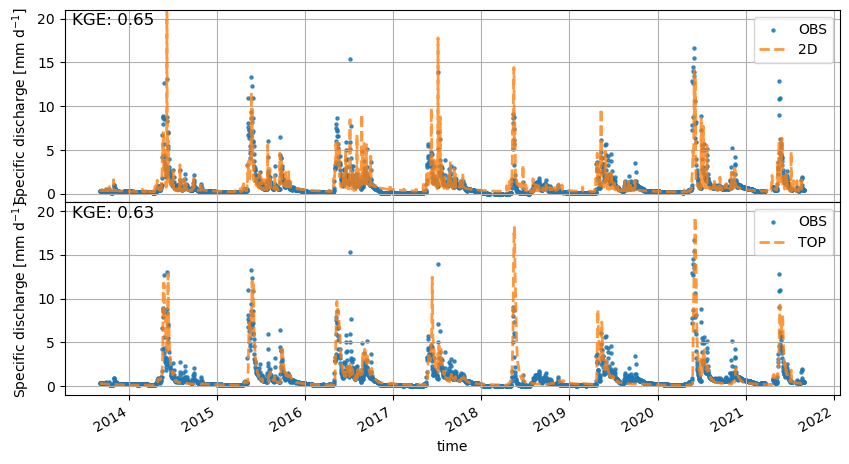

In [73]:
period = pd.date_range('2013-09-02', '2021-09-01', freq='D')
lw=2
alp=0.8
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2, 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])

#q.loc[period, '1_Lompolojanganoja'].plot(ax=ax0, linestyle='-', linewidth=lw, alpha=alp, label='OBS')
ax0.scatter(period, q.loc[period, '1_Lompolojanganoja'], alpha=0.8, s=5, label='OBS')
(res_2d['bucket_surface_runoff'].mean(dim=['lat', 'lon']).sel(time=period) + res_2d['soil_netflow_to_ditch'].mean(dim=['lat', 'lon']).sel(time=period)).plot(ax=ax0, color='tab:orange', alpha=alp, linewidth=lw, label='2D', linestyle='--')
#(res_top['bucket_surface_runoff'].mean(dim=['lat', 'lon']).sel(time=period) + res_top['top_baseflow'].sel(time=period)).plot(linewidth=lw, alpha=0.6, label='TOP')
#(res_top['bucket_surface_runoff'].mean(dim=['lat', 'lon']).sel(time=period) + res_top['top_baseflow'].sel(time=period)).plot(alpha=0.6, label='TOP')
ax0.legend()
#(res_top['bucket_surface_runoff'])

#q.loc[period, '1_Lompolojanganoja'].plot(ax=ax1,  linestyle='-', linewidth=lw, alpha=alp, label='OBS')
ax1.scatter(period, q.loc[period, '1_Lompolojanganoja'], alpha=0.8, s=5, label='OBS')
#(res_2d['bucket_surface_runoff'].mean(dim=['lat', 'lon']).sel(time=period) + res_2d['soil_netflow_to_ditch'].mean(dim=['lat', 'lon']).sel(time=period)).plot(alpha=0.6, label='2D')
(res_top['bucket_surface_runoff'].mean(dim=['lat', 'lon']).sel(time=period) + res_top['top_baseflow'].sel(time=period)).plot(ax=ax1, alpha=alp, label='TOP', color='tab:orange', linewidth=lw, linestyle='--')
ax1.legend()


ax0.text(0.01, 0.92, f'KGE: {d2kge}',
         fontsize=12, transform=ax0.transAxes)
ax1.text(0.01, 0.92, f'KGE: {topkge}',
         fontsize=12, transform=ax1.transAxes)

ax0.set_ylim([-1,21])
ax1.set_ylim([-1,21])

ax0.set_ylabel('Specific discharge [mm d$^{-1}$]')
ax1.set_ylabel('Specific discharge [mm d$^{-1}$]')

ax0.set_yticks(np.arange(0,21,5))
ax1.set_yticks(np.arange(0,21,5))

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig(f'specific_discharge_{today}.png', bbox_inches='tight', dpi=300)

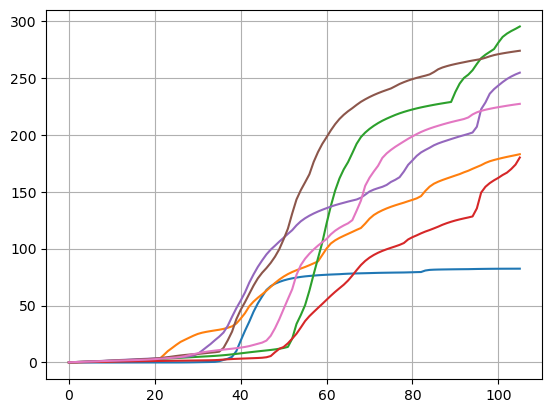

In [90]:
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2018-04-01':'2018-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2019-04-01':'2019-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2020-04-01':'2020-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2017-04-01':'2017-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2016-04-01':'2016-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2015-04-01':'2015-07-15'].to_list()))
plt.plot(np.nancumsum(q['1_Lompolojanganoja']['2014-04-01':'2014-07-15'].to_list()))

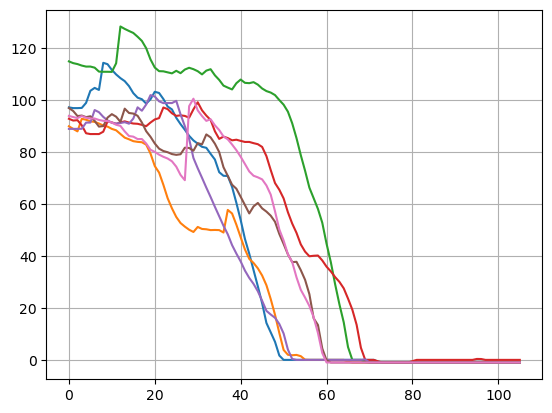

In [91]:
plt.plot(forc['snowdepth']['2018-04-01':'2018-07-15'].to_list())
plt.plot(forc['snowdepth']['2019-04-01':'2019-07-15'].to_list())
plt.plot(forc['snowdepth']['2020-04-01':'2020-07-15'].to_list())
plt.plot(forc['snowdepth']['2017-04-01':'2017-07-15'].to_list())
plt.plot(forc['snowdepth']['2016-04-01':'2016-07-15'].to_list())
plt.plot(forc['snowdepth']['2015-04-01':'2015-07-15'].to_list())
plt.plot(forc['snowdepth']['2014-04-01':'2014-07-15'].to_list())

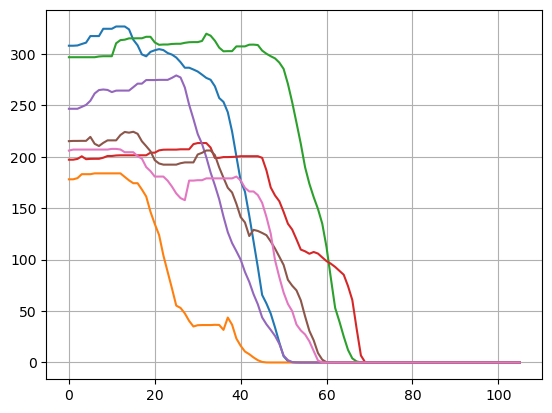

In [99]:
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2018-04-01','2018-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2019-04-01','2019-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2020-04-01','2020-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2017-04-01','2017-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2016-04-01','2016-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2015-04-01','2015-07-15')).mean(dim=['lat','lon']).values)
plt.plot(res_1d['canopy_snow_water_equivalent'].sel(time=slice('2014-04-01','2014-07-15')).mean(dim=['lat','lon']).values)

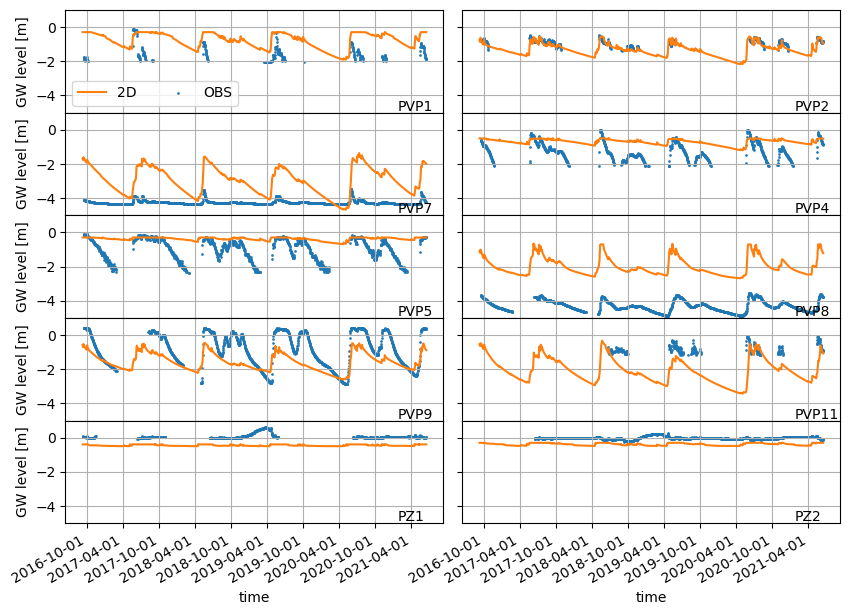

In [77]:
# temporal sar model obs

# SAR SPATIAL PLOTS
period = pd.date_range(gw.index[0], gw.index[-1], freq='D')

alp=0.5
meas_depth=10
lwidth = 2
text1 = [0.01, 0.02]
obsalp = 0.15
ylims = [-5,1]
ylimstemp = [0.08,0.4]
text1 = [0.88, 0.02]
scs = 1
salp=0.9
scc = 'tab:blue'
fig = plt.figure(figsize=(10,8))
gs = fig.add_gridspec(6, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])
ax9 = fig.add_subplot(gs[4, 0])
ax10 = fig.add_subplot(gs[4, 1])

pipe = 'PVP1'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax1, label='2D', color='tab:orange')
ax1.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
#gw[pipe].plot(ax=ax1, label='OBS')
ax1.set_ylim(ylims)
ax1.legend(ncol=2)

pipe = 'PVP2'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax2, label='2D', color='tab:orange')
ax2.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax2.set_ylim(ylims)

pipe = 'PVP7'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax3, label='2D', color='tab:orange')
ax3.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax3.set_ylim(ylims)

pipe = 'PVP4'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax4, label='2D', color='tab:orange')
ax4.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax4.set_ylim(ylims)

pipe = 'PVP5'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax5, label='2D', color='tab:orange')
ax5.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax5.set_ylim(ylims)

pipe = 'PVP8'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax6, label='2D', color='tab:orange')
ax6.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax6.set_ylim(ylims)

pipe = 'PVP9'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax7, label='2D', color='tab:orange')
ax7.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax7.set_ylim(ylims)

pipe = 'PVP11'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax8, label='2D', color='tab:orange')
ax8.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax8.set_ylim(ylims)

pipe = 'PZ1'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax9, label='2D', color='tab:orange')
ax9.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax9.set_ylim(ylims)

pipe = 'PZ2'
(res_2d['soil_ground_water_level'].sel(time=period, lat=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].y), 
                                      lon=float(gwc.loc[gwc['Pipe'] == pipe, 'geometry'].x), method='nearest')-0.3).plot(ax=ax10, label='2D', color='tab:orange')
ax10.scatter(period, gw[pipe], label='OBS', s=scs, color=scc, alpha=salp)
ax10.set_ylim(ylims)

ax1.set_ylabel('GW level [m]')
ax2.set_ylabel('')
ax3.set_ylabel('GW level [m]')
ax4.set_ylabel('')
ax5.set_ylabel('GW level [m]')
ax6.set_ylabel('')
ax7.set_ylabel('GW level [m]')
ax8.set_ylabel('')
ax9.set_ylabel('GW level [m]')
ax10.set_ylabel('')

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')
ax7.set_title('')
ax8.set_title('')
ax9.set_title('')
ax10.set_title('')

ax1.text(text1[0], text1[1], 'PVP1', fontsize=10, transform=ax1.transAxes)
ax2.text(text1[0], text1[1], 'PVP2', fontsize=10, transform=ax2.transAxes)
ax3.text(text1[0], text1[1], 'PVP7', fontsize=10, transform=ax3.transAxes)
ax4.text(text1[0], text1[1], 'PVP4', fontsize=10, transform=ax4.transAxes)
ax5.text(text1[0], text1[1], 'PVP5', fontsize=10, transform=ax5.transAxes)
ax6.text(text1[0], text1[1], 'PVP8', fontsize=10, transform=ax6.transAxes)
ax7.text(text1[0], text1[1], 'PVP9', fontsize=10, transform=ax7.transAxes)
ax8.text(text1[0], text1[1], 'PVP11', fontsize=10, transform=ax8.transAxes)
ax9.text(text1[0], text1[1], 'PZ1', fontsize=10, transform=ax9.transAxes)
ax10.text(text1[0], text1[1], 'PZ2', fontsize=10, transform=ax10.transAxes)

ax2.axes.yaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])
ax6.axes.yaxis.set_ticklabels([])
ax8.axes.yaxis.set_ticklabels([])
ax10.axes.yaxis.set_ticklabels([])

ax1.axes.xaxis.set_ticklabels([])
ax2.axes.xaxis.set_ticklabels([])
ax3.axes.xaxis.set_ticklabels([])
ax4.axes.xaxis.set_ticklabels([])
ax5.axes.xaxis.set_ticklabels([])
ax6.axes.xaxis.set_ticklabels([])
ax7.axes.xaxis.set_ticklabels([])
ax8.axes.xaxis.set_ticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0)

ax1.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax2.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax3.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax4.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax5.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax6.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax7.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax8.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax9.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))
ax10.set_xticks(pd.date_range(period[0], period[-1], freq='6MS'))

plt.savefig(f'gw_levels_{today}.png', bbox_inches='tight', dpi=300)

In [78]:
drycanopy_days = []
i = 0
for day in forc.index:
    if forc['rainfall'][day] == 0:
        if forc.iloc[i-1]['rainfall'] == 0:
            drycanopy_days.append(day)
    i += 1
drycanopy_days = pd.to_datetime(drycanopy_days)
drycanopy_days = drycanopy_days[drycanopy_days.isin(dates_spa)]

In [79]:
et_pairs = pd.DataFrame()

et_pairs['MOD_1D_NFOR'] = res_2d['total_evapotranspiration'].sel(time=drycanopy_days)[:,ht[0]-4:ht[0]+5,ht[1]-4:ht[1]+5].mean(dim=['lat','lon'])
et_pairs['MOD_1D_NWET'] = res_2d['total_evapotranspiration'].sel(time=drycanopy_days)[:,om[0]-4:om[0]+5,om[1]-4:om[1]+5].mean(dim=['lat','lon'])
et_pairs['MOD_1DA_NFOR'] = res_1d_ave['total_evapotranspiration'].sel(time=drycanopy_days)[:,ht[0]-4:ht[0]+5,ht[1]-4:ht[1]+5].mean(dim=['lat','lon'])
et_pairs['MOD_1DA_NWET'] = res_1d_ave['total_evapotranspiration'].sel(time=drycanopy_days)[:,om[0]-4:om[0]+5,om[1]-4:om[1]+5].mean(dim=['lat','lon'])
et_pairs.index = drycanopy_days
et_pairs['OBS_NFOR'] = et.loc[(et['ET_NFOR_flag'] < 1.5) & (et.index.isin(drycanopy_days)), 'ET_NFOR']
et_pairs['OBS_NWET'] = et.loc[(et['ET_NWET_flag'] < 1.5) & (et.index.isin(drycanopy_days)), 'ET_NWET']
et_pairs[et_pairs < 0] = np.nan
et_pairs.loc[(et_pairs.index.year == 2016), 'OBS_NFOR'] = np.nan

r2_et_kent = R2_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1D_NFOR'])
mbe_et_kent = MBE_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1D_NFOR'])
mae_et_kent = MAE_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1D_NFOR'])

r2_et_lomp = R2_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1D_NWET'])
mbe_et_lomp = MBE_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1D_NWET'])
mae_et_lomp = MAE_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1D_NWET'])

##
r2_et_kent_ave = R2_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1DA_NFOR'])
mbe_et_kent_ave = MBE_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1DA_NFOR'])
mae_et_kent_ave = MAE_metrics(et_pairs, columns=['OBS_NFOR', 'MOD_1DA_NFOR'])

r2_et_lomp_ave = R2_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1DA_NWET'])
mbe_et_lomp_ave = MBE_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1DA_NWET'])
mae_et_lomp = MAE_metrics(et_pairs, columns=['OBS_NWET', 'MOD_1DA_NWET'])

In [32]:
mae_et_kent

0.63

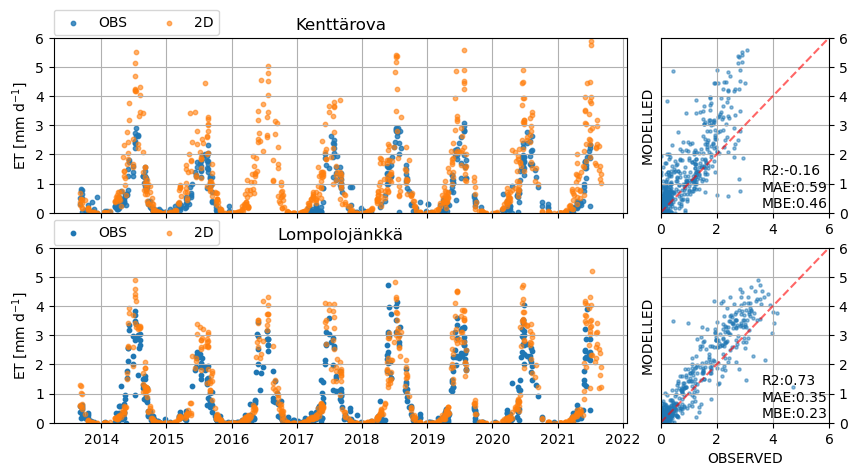

In [119]:
scatlims = [0, 6]
linew = 2
ss=5
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(2, 4)

ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3])

ax3 = fig.add_subplot(gs[1, 0:3])
ax4 = fig.add_subplot(gs[1, 3])

ax1.scatter(et_pairs.index, 
            et_pairs['OBS_NFOR'], 
            s=10, color='tab:blue', alpha=0.8, label='OBS')
#et_pairs['MOD_1DA_NFOR'].plot(ax=ax1, alpha=0.6, label='1D (homog.canopy)', linewidth=linew, linestyle='--', color='black')
#et_pairs['MOD_1D_NFOR'].plot(ax=ax1, alpha=0.6, label='1D', linewidth=linew, color='tab:orange')
ax1.scatter(et_pairs.index, 
            et_pairs['MOD_1D_NFOR'], 
            s=10,  alpha=0.6, label='2D', color='tab:orange')
#res_2d['total_evapotranspiration'][:,ht[0]-5:ht[0]+5,ht[1]-5:ht[1]+5].mean(dim=['lat','lon']).plot(ax=ax1, alpha=0.5, label='MOD', color='tab:orange')


#ax1.scatter((et.loc[(et['ET_NFOR_flag'] < 1.5) & (et.index.isin(drycanopy_days))].index), 
#            et.loc[(et['ET_NFOR_flag'] < 1.5) & (et.index.isin(drycanopy_days)), 'ET_NFOR'], 
#            s=10, color='tab:blue', alpha=0.8, label='OBS')

ax2.scatter(et_pairs['OBS_NFOR'], et_pairs['MOD_1D_NFOR'], s=ss, alpha=0.5)
#ax2.scatter(et_pairs['OBS_NFOR'], et_pairs['MOD_1DA_NFOR'], s=ss, alpha=0.5, color='black')

ax3.scatter(et_pairs.index, 
            et_pairs['OBS_NWET'], 
            s=10, color='tab:blue', alpha=1, label='OBS')
#et_pairs['MOD_1DA_NWET'].plot(ax=ax3, alpha=0.6, label='1D (homog.canopy)', linestyle='--', linewidth=linew, color='black')
#et_pairs['MOD_1D_NWET'].plot(ax=ax3, alpha=0.6, label='1D', linewidth=linew, color='tab:orange')
ax3.scatter(et_pairs.index, 
            et_pairs['MOD_1D_NWET'], 
            s=10,  alpha=0.6, label='2D', color='tab:orange')


ax4.scatter(et_pairs['OBS_NWET'], et_pairs['MOD_1D_NWET'], s=ss, alpha=0.5)
#ax4.scatter(et_pairs['OBS_NWET'], et_pairs['MOD_1DA_NWET'], s=ss, alpha=0.5, color='black')


ax1.legend(ncol=2, bbox_to_anchor=(0.3, 1.2))
ax3.legend(ncol=2, bbox_to_anchor=(0.3, 1.2))


ax1.set_ylim(scatlims)
ax1.set_title('Kenttärova')
ax3.set_title('Lompolojänkkä')
ax1.set_xticklabels('')

ax1.set_ylabel('ET [mm d$^{-1}$]')
ax3.set_ylabel('ET [mm d$^{-1}$]')

ax2.set_ylim(scatlims)
ax3.set_ylim(scatlims)
ax4.set_ylim(scatlims)

ax2.plot(scatlims, scatlims, 'r--', alpha=0.6)
ax2.set_ylabel('MODELLED')

ax2.set_xlim(scatlims)

ax4.plot(scatlims, scatlims, 'r--', alpha=0.6)
ax4.set_ylim(scatlims)
ax4.set_xlim(scatlims)
ax4.set_ylabel('MODELLED')
ax4.set_xlabel('OBSERVED')

ax2.yaxis.tick_right()
ax4.yaxis.tick_right()


ax2.text(0.6, 0.03, f'R2:{r2_et_kent}\nMAE:{mae_et_kent}\nMBE:{mbe_et_kent}',
         fontsize=10, transform=ax2.transAxes)
ax4.text(0.6, 0.03, f'R2:{r2_et_lomp}\nMAE:{mae_et_lomp}\nMBE:{mbe_et_lomp}',
         fontsize=10, transform=ax4.transAxes)

plt.savefig(f'et_sites_{today}.png', bbox_inches='tight', dpi=300)

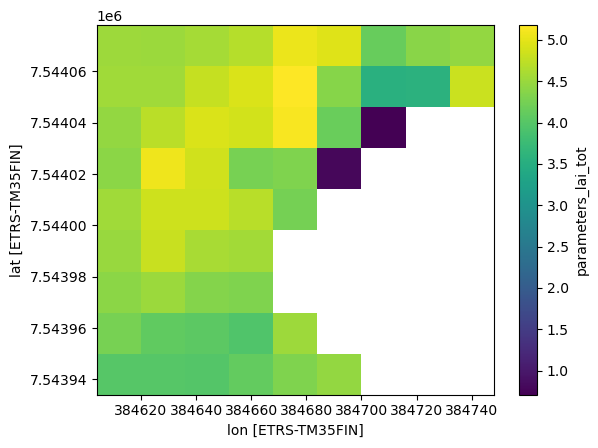

In [13]:
res_1d['parameters_lai_tot'][ht[0]-4:ht[0]+5,ht[1]-4:ht[1]+5].plot()

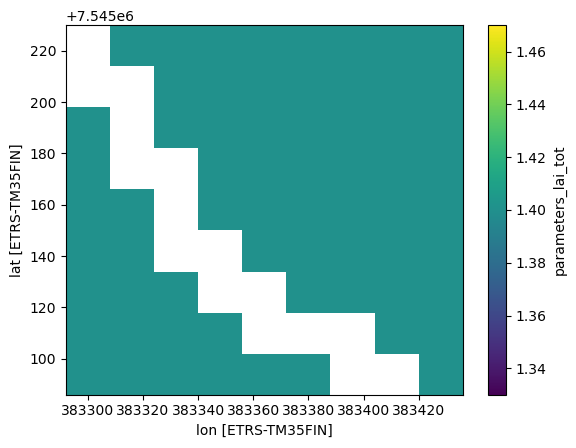

In [8]:
res_1d_ave['parameters_lai_tot'][om[0]-4:om[0]+5,om[1]-4:om[1]+5].plot()

In [9]:
print('LAI conif', res_2d['parameters_lai_conif'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI decid max', res_2d['parameters_lai_decid_max'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI shrub', res_2d['parameters_lai_shrub'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI grass', res_2d['parameters_lai_grass'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)

LAI conif 2.523273
LAI decid max 1.0337176
LAI shrub 0.52649087
LAI grass 0.19551872


In [10]:
print('LAI conif', res_1d_ave['parameters_lai_conif'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI decid max', res_1d_ave['parameters_lai_decid_max'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI shrub', res_1d_ave['parameters_lai_shrub'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)
print('LAI grass', res_1d_ave['parameters_lai_grass'][ht[0]-5:ht[0]+6,ht[1]-5:ht[1]+6].mean().data)

LAI conif 2.0
LAI decid max 0.10000001
LAI shrub 2.220446e-16
LAI grass 2.220446e-16


In [11]:
print('LAI conif', res_2d['parameters_lai_conif'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI decid max', res_2d['parameters_lai_decid_max'][ht[0]-5:ht[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI shrub', res_2d['parameters_lai_shrub'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI grass', res_2d['parameters_lai_grass'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)

LAI conif 0.014657851
LAI decid max 1.1019505
LAI shrub 0.4730439
LAI grass 0.61659014


In [12]:
print('LAI conif', res_1d_ave['parameters_lai_conif'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI decid max', res_1d_ave['parameters_lai_decid_max'][ht[0]-5:ht[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI shrub', res_1d_ave['parameters_lai_shrub'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)
print('LAI grass', res_1d_ave['parameters_lai_grass'][om[0]-5:om[0]+6,om[1]-5:om[1]+6].mean().data)

LAI conif 0.019607844
LAI decid max 0.11786299
LAI shrub 0.69313705
LAI grass 0.69313705


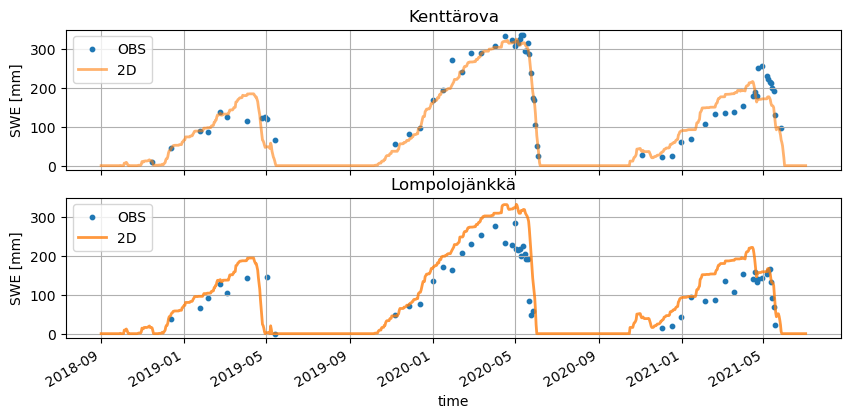

In [117]:
ylims = [-10, 350]
linew = 2
ss=10

start = swe.index[0]
end = swe.index[-1]

fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(2, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])


ax1.scatter(swe[start:end].index, 
            swe['kenttarova'][start:end], 
            s=ss, color='tab:blue', alpha=1, label='OBS')
res_2d['canopy_snow_water_equivalent'].sel(time=slice(start, end))[:, ht[0], ht[1]].plot(
    ax=ax1, alpha=0.6, label='2D', linewidth=linew, linestyle='-', color='tab:orange')

ax2.scatter(swe[start:end].index, 
            swe['lompolojankka'][start:end], 
            s=ss, color='tab:blue', alpha=1, label='OBS')
res_2d['canopy_snow_water_equivalent'].sel(time=slice(start, end))[:, om[0], om[1]].plot(
    ax=ax2, alpha=0.8, label='2D', linewidth=linew, linestyle='-', color='tab:orange')

ax1.legend()
ax2.legend(loc='upper left')

ax1.set_title('Kenttärova')
ax2.set_title('Lompolojänkkä')
ax1.set_xticklabels('')
ax1.set_xlabel('')

ax1.set_ylabel('SWE [mm]')
ax2.set_ylabel('SWE [mm]')

ax1.set_ylim(ylims)
ax2.set_ylim(ylims)

plt.savefig(f'swe_sites_{today}.png', bbox_inches='tight', dpi=300)